Code 2 is re-computed here without the heatmap in order to be able to perform feature selection and machine learning directly.

Moreover, this code has been executed three different times by using the different radiomic files obtained by each brain region. For hippocampus: firstordertot.csv, for amygdala: firstordertot_amy.csv, for thalamus: firstordertot_thal.csv and so on.

In [1]:
import os 
import numpy as np
import nibabel as nib
import pandas as pd
import SimpleITK as sitk 
from radiomics import featureextractor, getFeatureClasses
import matplotlib.pyplot as plt
import csv
import seaborn as sns 
from scipy import stats
from sklearn.feature_selection import VarianceThreshold
import scipy.cluster.hierarchy as spc
from scipy.cluster.hierarchy import ward, fcluster
from scipy.spatial.distance import pdist
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from pandas import read_csv

In [2]:
nom_carpetes = [3077, 3078, 3079, 3121, 3329, 3536, 3542, 3543, 3544, 3076, 3148, 3157, 3164, 3171, 3265, 3288, 
                3289, 3457, 4972, 4979, 4980, 4996, 4998, 5007, 5009, 5013, 5014, 5018, 5021, 5042, 5056, 5057, 
                5063, 5064, 5065, 5066, 5086, 5087, 5097, 5102, 5104, 5113, 5114, 4970, 4971, 4978, 4985, 4986, 
                4987, 4993, 4994, 4997, 5008, 5019, 5020, 5032, 5033, 5034, 5041, 5058, 5098, 5103, 5105, 5378]

nom_carpetes_train = [3077, 3078, 3121, 3536, 3542, 3544, 4979, 4996, 4998, 5007, 5009, 5013, 5014, 5021, 5042, 
                      5056, 5057, 5063, 5064, 5065, 5066, 5086, 5087, 5097, 5102, 5104, 5113, 5114, 
                      3076, 3148, 3171, 3265, 3289, 3457, 4970, 4971, 4978, 4985, 4986, 4993, 4997, 5008, 
                      5020, 5032, 5033, 5034, 5041, 5058, 5098, 5103, 5105, 5378]           

path_ = "/Users/elisabetsorribes/Desktop/TFG/ALL DATASETS/"

nom_temps= ['t1', 't2', 't3', 't4', 't5']

In [3]:
counter_firstorder = 18
counter_shape = 14
counter_glcm = 24
counter_glrlm = 16
counter_glszm = 16
counter_gldm = 14
counter_ngtdm = 5
num_total_features = counter_firstorder + counter_shape + counter_glcm + counter_glrlm + counter_glszm + counter_gldm + counter_ngtdm

nom_temps = ['t1', 't2', 't3', 't4', 't5']
num_temps = len(nom_temps)

num_casos_totals = len(nom_carpetes_train)*num_temps

fitxers_features = ['firstordertot.csv', 'shapetot.csv', 'glcmtot.csv', 'gldmtot.csv', 'glrlmtot.csv', 'glszmtot.csv', 'ngtdmtot.csv']
path_ = "/Users/elisabetsorribes/Desktop/TFG/ALL DATASETS"

matriu_variance = np.zeros((num_total_features, num_casos_totals)) 

## Feature selection. Exclusion of non-reproducible and irrelevant features 

In [4]:
def get_feature(i):
    switcher={
        0: 'original_firstorder_10Percentile',
        1: 'original_firstorder_90Percentile',
        2: 'original_firstorder_Energy',
        3: 'original_firstorder_Entropy', 
        4: 'original_firstorder_InterquartileRange',
        5: 'original_firstorder_Kurtosis',
        6: 'original_firstorder_Maximum',
        7: 'original_firstorder_MeanAbsoluteDeviation',
        8: 'original_firstorder_Mean',
        9: 'original_firstorder_Median',
        10: 'original_firstorder_Minimum',
        11: 'original_firstorder_Range',
        12: 'original_firstorder_RobustMeanAbsoluteDeviation',
        13: 'original_firstorder_RootMeanSquared',
        14: 'original_firstorder_Skewness',
        15: 'original_firstorder_TotalEnergy',
        16: 'original_firstorder_Uniformity',
        17: 'original_firstorder_Variance',
        18: 'original_shape_Elongation',
        19: 'original_shape_Flatness',
        20: 'original_shape_LeastAxisLength',
        21: 'original_shape_MajorAxisLength',
        22: 'original_shape_Maximum2DDiameterColumn',
        23: 'original_shape_Maximum2DDiameterRow',
        24: 'original_shape_Maximum2DDiameterSlice',
        25: 'original_shape_Maximum3DDiameter',
        26: 'original_shape_MeshVolume',
        27: 'original_shape_MinorAxisLength',
        28: 'original_shape_Sphericity',
        29: 'original_shape_SurfaceArea',
        30: 'original_shape_SurfaceVolumeRatio',
        31: 'original_shape_VoxelVolume',
        32: 'original_glcm_Autocorrelation',
        33: 'original_glcm_ClusterProminence',
        34: 'original_glcm_ClusterShade',
        35: 'original_glcm_ClusterTendency',
        36: 'original_glcm_Contrast',
        37: 'original_glcm_Correlation',
        38: 'original_glcm_DifferenceAverage',
        39: 'original_glcm_DifferenceEntropy', 
        40: 'original_glcm_DifferenceVariance',
        41: 'original_glcm_Id',
        42: 'original_glcm_Idm',
        43: 'original_glcm_Idmn',
        44: 'original_glcm_Idn',
        45: 'original_glcm_Imc1',
        46: 'original_glcm_Imc2',
        47: 'original_glcm_InverseVariance', 
        48: 'original_glcm_JointAverage',
        49: 'original_glcm_JointEnergy',
        50: 'original_glcm_JointEntropy',
        51: 'original_glcm_MCC', 
        52: 'original_glcm_MaximumProbability',
        53: 'original_glcm_SumAverage',
        54: 'original_glcm_SumEntropy',
        55: 'original_glcm_SumSquares',
        56: 'original_glrlm_GrayLevelNonUniformity',
        57: 'original_glrlm_GrayLevelNonUniformityNormalized',
        58: 'original_glrlm_GrayLevelVariance',
        59: 'original_glrlm_HighGrayLevelRunEmphasis',
        60: 'original_glrlm_LongRunEmphasis',
        61: 'original_glrlm_LongRunHighGrayLevelEmphasis', 
        62: 'original_glrlm_LongRunLowGrayLevelEmphasis',
        63: 'original_glrlm_LowGrayLevelRunEmphasis', 
        64: 'original_glrlm_RunEntropy',
        65: 'original_glrlm_RunLengthNonUniformity',
        66: 'original_glrlm_RunLengthNonUniformityNormalized',
        67: 'original_glrlm_RunPercentage',
        68: 'original_glrlm_RunVariance', 
        69: 'original_glrlm_ShortRunEmphasis',
        70: 'original_glrlm_ShortRunHighGrayLevelEmphasis',
        71: 'original_glrlm_ShortRunLowGrayLevelEmphasis',
        72: 'original_glszm_GrayLevelNonUniformity', 
        73: 'original_glszm_GrayLevelNonUniformityNormalized',
        74: 'original_glszm_GrayLevelVariance',
        75: 'original_glszm_HighGrayLevelZoneEmphasis', 
        76: 'original_glszm_LargeAreaEmphasis', 
        77: 'original_glszm_LargeAreaHighGrayLevelEmphasis', 
        78: 'original_glszm_LargeAreaLowGrayLevelEmphasis', 
        79: 'original_glszm_LowGrayLevelZoneEmphasis', 
        80: 'original_glszm_SizeZoneNonUniformity',
        81: 'original_glszm_SizeZoneNonUniformityNormalized', 
        82: 'original_glszm_SmallAreaEmphasis', 
        83: 'original_glszm_SmallAreaHighGrayLevelEmphasis',
        84: 'original_glszm_SmallAreaLowGrayLevelEmphasis', 
        85: 'original_glszm_ZoneEntropy',
        86: 'original_glszm_ZonePercentage', 
        87: 'original_glszm_ZoneVariance',
        88: 'original_gldm_DependenceEntropy',
        89: 'original_gldm_DependenceNonUniformity', 
        90: 'original_gldm_DependenceNonUniformityNormalized',
        91: 'original_gldm_DependenceVariance',
        92: 'original_gldm_GrayLevelNonUniformity',  
        93: 'original_gldm_GrayLevelVariance',
        94: 'original_gldm_HighGrayLevelEmphasis',
        95: 'original_gldm_LargeDependenceEmphasis',
        96: 'original_gldm_LargeDependenceHighGrayLevelEmphasis',
        97: 'original_gldm_LargeDependenceLowGrayLevelEmphasis',
        98: 'original_gldm_LowGrayLevelEmphasis',
        99: 'original_gldm_SmallDependenceEmphasis',
        100: 'original_gldm_SmallDependenceHighGrayLevelEmphasis',
        101: 'original_gldm_SmallDependenceLowGrayLevelEmphasis',
        102: 'original_ngtdm_Busyness',
        103: 'original_ngtdm_Coarseness', 
        104: 'original_ngtdm_Complexity',
        105: 'original_ngtdm_Contrast',
        106: 'original_ngtdm_Strength' 
    }
    return switcher.get(i)

In [5]:
path_ = "/Users/elisabetsorribes/Desktop/TFG/ALL DATASETS"

for num in range(num_total_features):
    
    vector_iterador = [] 
    variable = get_feature(num)
    
    if (num == 0) or (0 < num <= 17):
        fitxer = 'firstordertot.csv'
    elif (17 < num <= 31):
        fitxer = 'shapetot.csv'
    elif (31 < num <= 55):
        fitxer = 'glcmtot.csv'
    elif (55 < num <= 71):
        fitxer = 'glrlmtot.csv'
    elif (71 < num <= 87):
        fitxer = 'glszmtot.csv'
    elif (87 < num <= 101):
        fitxer = 'gldmtot.csv'
    else:
        fitxer = 'ngtdmtot.csv'
    
    for case in nom_carpetes_train:
            
        for temps in nom_temps:
            path_1 = str(case) + "/" + str(temps) + "/" + str(fitxer)
            data_path = os.path.join(path_,path_1)
            #print(data_path)
            
            if os.path.isfile(data_path): 
                with open(data_path) as Features: 
                    reader = csv.DictReader(Features, delimiter=',', quotechar=',', quoting=csv.QUOTE_MINIMAL)
                
                    for row in reader: 
                        valor = row[variable]
                        valor = float(valor)
                        vector_iterador.append(valor)
            else:
                vector_iterador.append(np.nan)

    matriu_variance[num] = vector_iterador
    
    
matriu_variance_bo = np.transpose(matriu_variance)

with open('/Users/elisabetsorribes/Desktop/TFG/ALL DATASETS/matrizvariancedef.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(matriu_variance_bo)

In [6]:
#High variance
threshold_high = VarianceThreshold(threshold=0.8) 
matriu_high = threshold_high.fit_transform(matriu_variance_bo)

with open('/Users/elisabetsorribes/Desktop/TFG/ALL DATASETS/matrizvariancehigh.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(matriu_high)

#Low variance
threshold_low = VarianceThreshold(threshold=0.2)
matriu_low = threshold_low.fit_transform(matriu_variance_bo)

with open('/Users/elisabetsorribes/Desktop/TFG/ALL DATASETS/matrizvariancelow.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(matriu_low)

#Matriu with high+low variance
matriu_def = threshold_low.fit_transform(matriu_high)
print(matriu_def.shape[1])

with open('/Users/elisabetsorribes/Desktop/TFG/ALL DATASETS/matrizvariancedefinitiva.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(matriu_def) 

50


In [7]:
#Here it will be removed features with high variance. 
features_remaining = []
num_features_remaining = matriu_high.shape[1]

for i in range(num_features_remaining): 
    
    path_1 = "/Users/elisabetsorribes/Desktop/TFG/ALL DATASETS/3077/t1" 
    valor = matriu_high[0][i] #50 values. 
    
    for feat_fitxer in fitxers_features: 
        data_path = os.path.join(path_1,feat_fitxer)
        #print(data_path)
        
        with open(data_path) as Features: 
            reader = csv.reader(Features, delimiter=',', quotechar=',', quoting=csv.QUOTE_MINIMAL)
            
            contador = 0 
            
            for row in reader: 
                contador = contador + 1
                
                if (contador%2 == 0): 
                    valors_features = tuple(row)
                
                else: 
                    noms_features = tuple(row)
                    
            for llarg in range(len(valors_features)):
                valor_2 = float(valors_features[llarg])
                        
                if (valor == valor_2):
                    features_remaining.append(noms_features[llarg])
                    
print(features_remaining) 

['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_InterquartileRange', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_TotalEnergy', 'original_firstorder_Variance', 'original_shape_MeshVolume', 'original_shape_SurfaceArea', 'original_shape_VoxelVolume', 'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_ClusterTendency', 'original_glcm_Contrast', 'original_glcm_DifferenceAverage', 'original_glcm_DifferenceVariance', 'original_glcm_JointAverage', 'original_glcm_SumAverage', 'original_glcm_SumSquares', 'original_glrlm_GrayLevelNonUniformity', 'original_glrlm_GrayLevelVariance', 'original_glrlm_HighGray

In [8]:
#Here it will be removed features with low variance.  

features_remaining = []
num_features_remaining = matriu_low.shape[1]

for i in range(num_features_remaining): 
    
    path_1 = path_ = "/Users/elisabetsorribes/Desktop/TFG/ALL DATASETS/3077/t1" 
    valor = matriu_low[0][i]
    
    for feat_fitxer in fitxers_features:
        data_path = os.path.join(path_1,feat_fitxer)
        
        with open(data_path) as Features: 
            reader = csv.reader(Features, delimiter=',', quotechar=',', quoting=csv.QUOTE_MINIMAL)
            
            contador = 0 
            
            for row in reader: 
                contador = contador + 1
                
                if (contador%2 == 0): 
                    valors_features = tuple(row)
                
                else: 
                    noms_features = tuple(row)
                    
            for llarg in range(len(valors_features)):
                valor_2 = float(valors_features[llarg])
                        
                if (valor == valor_2):
                    features_remaining.append(noms_features[llarg])        
                
print(features_remaining) 

['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_InterquartileRange', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_TotalEnergy', 'original_firstorder_Variance', 'original_shape_Maximum2DDiameterRow', 'original_shape_MeshVolume', 'original_shape_SurfaceArea', 'original_shape_VoxelVolume', 'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_ClusterTendency', 'original_glcm_Contrast', 'original_glcm_DifferenceAverage', 'original_glcm_DifferenceVariance', 'original_glcm_JointAverage', 'original_glcm_JointEntropy', 'original_glcm_SumAverage', 'original_glcm_SumSquares', 'original_glrlm_GrayLevelNonUnif

In [9]:
features_remaining = []
num_features_remaining = matriu_def.shape[1]

for i in range(50): 
    
    path_1 = path_ = "/Users/elisabetsorribes/Desktop/TFG/ALL DATASETS/3077/t1" 
    valor = matriu_def[0][i]
    #print(valor)
    #print()
    
    for feat_fitxer in fitxers_features:
        data_path = os.path.join(path_1,feat_fitxer)
        
        with open(data_path) as Features: 
            reader = csv.reader(Features, delimiter=',', quotechar=',', quoting=csv.QUOTE_MINIMAL)
            
            contador = 0 
            
            for row in reader: 
                contador = contador + 1
                
                if (contador%2 == 0): 
                    valors_features = tuple(row)
                
                else: 
                    noms_features = tuple(row)
                    
            for llarg in range(len(valors_features)):
                valor_2 = float(valors_features[llarg])
                        
                if (valor == valor_2):
                    features_remaining.append(noms_features[llarg])
                
    
print(features_remaining) 

['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_InterquartileRange', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_TotalEnergy', 'original_firstorder_Variance', 'original_shape_MeshVolume', 'original_shape_SurfaceArea', 'original_shape_VoxelVolume', 'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_ClusterTendency', 'original_glcm_Contrast', 'original_glcm_DifferenceAverage', 'original_glcm_DifferenceVariance', 'original_glcm_JointAverage', 'original_glcm_SumAverage', 'original_glcm_SumSquares', 'original_glrlm_GrayLevelNonUniformity', 'original_glrlm_GrayLevelVariance', 'original_glrlm_HighGray

## Feature selection. Evolution of radiomic features in heatmaps

In [10]:
num_casos = len(nom_carpetes_train) #52 cases

#Intensity (14)
matriu_original_firstorder_10Percentile = np.zeros((num_casos,num_temps))
matriu_original_firstorder_90Percentile = np.zeros((num_casos,num_temps))
matriu_original_firstorder_Energy = np.zeros((num_casos,num_temps))
matriu_original_firstorder_InterquartileRange = np.zeros((num_casos,num_temps))
matriu_original_firstorder_Maximum = np.zeros((num_casos,num_temps))
matriu_original_firstorder_MeanAbsoluteDeviation = np.zeros((num_casos,num_temps))
matriu_original_firstorder_Mean = np.zeros((num_casos,num_temps))
matriu_original_firstorder_Median = np.zeros((num_casos,num_temps))
matriu_original_firstorder_Minimum = np.zeros((num_casos,num_temps))
matriu_original_firstorder_Range = np.zeros((num_casos,num_temps))
matriu_original_firstorder_RobustMeanAbsoluteDeviation = np.zeros((num_casos,num_temps))
matriu_original_firstorder_RootMeanSquared = np.zeros((num_casos,num_temps))
matriu_original_firstorder_TotalEnergy = np.zeros((num_casos,num_temps))
matriu_original_firstorder_Variance = np.zeros((num_casos,num_temps))


#Shape (3)
matriu_original_shape_MeshVolume = np.zeros((num_casos,num_temps))
matriu_original_shape_SurfaceArea = np.zeros((num_casos,num_temps))
matriu_original_shape_VoxelVolume = np.zeros((num_casos,num_temps))

#GLCM (10)
matriu_original_glcm_Autocorrelation = np.zeros((num_casos,num_temps))
matriu_original_glcm_ClusterProminence = np.zeros((num_casos,num_temps))
matriu_original_glcm_ClusterShade = np.zeros((num_casos,num_temps))
matriu_original_glcm_ClusterTendency = np.zeros((num_casos,num_temps))
matriu_original_glcm_Contrast = np.zeros((num_casos,num_temps))
matriu_original_glcm_DifferenceAverage = np.zeros((num_casos,num_temps))
matriu_original_glcm_DifferenceVariance = np.zeros((num_casos,num_temps))
matriu_original_glcm_JointAverage = np.zeros((num_casos,num_temps))
matriu_original_glcm_SumAverage = np.zeros((num_casos,num_temps))
matriu_original_glcm_SumSquares = np.zeros((num_casos,num_temps))

#GLRLM (6)
matriu_original_glrlm_GrayLevelNonUniformity = np.zeros((num_casos,num_temps))
matriu_original_glrlm_GrayLevelVariance = np.zeros((num_casos,num_temps))
matriu_original_glrlm_HighGrayLevelRunEmphasis = np.zeros((num_casos,num_temps))
matriu_original_glrlm_LongRunHighGrayLevelEmphasis = np.zeros((num_casos,num_temps))
matriu_original_glrlm_RunLengthNonUniformity = np.zeros((num_casos,num_temps))
matriu_original_glrlm_ShortRunHighGrayLevelEmphasis = np.zeros((num_casos,num_temps))

#GLSZM (8)
matriu_original_glszm_GrayLevelNonUniformity = np.zeros((num_casos,num_temps))
matriu_original_glszm_GrayLevelVariance = np.zeros((num_casos,num_temps))
matriu_original_glszm_HighGrayLevelZoneEmphasis = np.zeros((num_casos,num_temps))
matriu_original_glszm_LargeAreaEmphasis = np.zeros((num_casos,num_temps))
matriu_original_glszm_LargeAreaHighGrayLevelEmphasis = np.zeros((num_casos,num_temps))
matriu_original_glszm_SizeZoneNonUniformity = np.zeros((num_casos,num_temps))
matriu_original_glszm_SmallAreaHighGrayLevelEmphasis = np.zeros((num_casos,num_temps))
matriu_original_glszm_ZoneVariance = np.zeros((num_casos,num_temps))

#GLDM (7)
matriu_original_gldm_DependenceNonUniformity = np.zeros((num_casos,num_temps))
matriu_original_gldm_GrayLevelNonUniformity = np.zeros((num_casos,num_temps))
matriu_original_gldm_GrayLevelVariance = np.zeros((num_casos,num_temps))
matriu_original_gldm_HighGrayLevelEmphasis = np.zeros((num_casos,num_temps))
matriu_original_gldm_LargeDependenceEmphasis = np.zeros((num_casos,num_temps))
matriu_original_gldm_LargeDependenceHighGrayLevelEmphasis = np.zeros((num_casos,num_temps))
matriu_original_gldm_SmallDependenceHighGrayLevelEmphasis = np.zeros((num_casos,num_temps))

#NGTDM (2)
matriu_original_ngtdm_Complexity = np.zeros((num_casos,num_temps))
matriu_original_ngtdm_Strength = np.zeros((num_casos,num_temps))

In [11]:
path_ = "/Users/elisabetsorribes/Desktop/TFG/ALL DATASETS/"

for i in range(len(nom_carpetes_train)): 
    case = nom_carpetes_train[i]
    
    for feat in features_remaining: 
        iterador = []
        
        if 'original_firstorder_' in feat:
            fitxer = 'firstordertot.csv'
        elif 'original_shape_' in feat:
            fitxer = 'shapetot.csv'
        elif 'original_glcm_' in feat:
            fitxer = 'glcmtot.csv'
        elif 'original_glrlm_' in feat:
            fitxer = 'glrlmtot.csv'
        elif 'original_glszm_' in feat:
            fitxer = 'glszmtot.csv'
        elif 'original_gldm_' in feat:
            fitxer = 'gldmtot.csv'
        else:
            fitxer = 'ngtdmtot.csv'
    
        for temps in nom_temps: 
            path_1 = str(case) + "/" + str(temps) + "/" + str(fitxer)
            data_path = os.path.join(path_,path_1)
            
            if os.path.isfile(data_path):
                with open(data_path) as Features: 
                    reader = csv.DictReader(Features, delimiter=',', quotechar=',', quoting=csv.QUOTE_MINIMAL)
                
                    for row in reader: 
                        valor = row[feat]
                        iterador.append(valor)
            else:
                iterador.append(np.NaN)
    
                
            if (len(iterador) == 5) and (feat == 'original_firstorder_10Percentile'):  #1      
                matriu_original_firstorder_10Percentile[i] = iterador
            
            elif (len(iterador) == 5) and (feat == 'original_firstorder_90Percentile'): #2
                matriu_original_firstorder_90Percentile[i] = iterador
                
            elif (len(iterador) == 5) and (feat == 'original_firstorder_Energy'): #3
                matriu_original_firstorder_Energy[i] = iterador
                
            elif (len(iterador) == 5) and (feat == 'original_firstorder_InterquartileRange'): #4
                matriu_original_firstorder_InterquartileRange[i] = iterador
            
            elif (len(iterador) == 5) and (feat == 'original_firstorder_Maximum'): #5
                matriu_original_firstorder_Maximum[i] = iterador
                
            elif (len(iterador) == 5) and (feat == 'original_firstorder_MeanAbsoluteDeviation'): #6
                matriu_original_firstorder_MeanAbsoluteDeviation[i] = iterador
            
            elif (len(iterador) == 5) and (feat == 'original_firstorder_Mean'): #7
                matriu_original_firstorder_Mean[i] = iterador
            
            elif (len(iterador) == 5) and (feat == 'original_firstorder_Median'): #8
                matriu_original_firstorder_Median[i] = iterador
            
            elif (len(iterador) == 5) and (feat == 'original_firstorder_Minimum'): #9
                matriu_original_firstorder_Minimum[i] = iterador
            
            elif (len(iterador) == 5) and (feat == 'original_firstorder_Range'): #10
                matriu_original_firstorder_Range[i] = iterador
            
            elif (len(iterador) == 5) and (feat == 'original_firstorder_RobustMeanAbsoluteDeviation'): #11
                matriu_original_firstorder_RobustMeanAbsoluteDeviation[i] = iterador
            
            elif (len(iterador) == 5) and (feat == 'original_firstorder_RootMeanSquared'): #12
                matriu_original_firstorder_RootMeanSquared[i] = iterador
            
            elif (len(iterador) == 5) and (feat == 'original_firstorder_TotalEnergy'): #13
                matriu_original_firstorder_TotalEnergy[i] = iterador
                
            elif (len(iterador) == 5) and (feat == 'original_firstorder_Variance'): #14
                matriu_original_firstorder_Variance[i] = iterador
            
            elif (len(iterador) == 5) and (feat == 'original_shape_MeshVolume'): #15
                matriu_original_shape_MeshVolume[i] = iterador
            
            elif (len(iterador) == 5) and (feat == 'original_shape_SurfaceArea'): #16
                matriu_original_shape_SurfaceArea[i] = iterador
            
            elif (len(iterador) == 5) and (feat == 'original_shape_VoxelVolume'): #17
                matriu_original_shape_VoxelVolume[i] = iterador
            
            elif (len(iterador) == 5) and (feat == 'original_glcm_Autocorrelation'): #18       
                matriu_original_glcm_Autocorrelation[i] = iterador
            
            elif (len(iterador) == 5) and (feat == 'original_glcm_ClusterProminence'): #19
                matriu_original_glcm_ClusterProminence[i] = iterador
                
            elif (len(iterador) == 5) and (feat == 'original_glcm_ClusterShade'): #20
                matriu_original_glcm_ClusterShade[i] = iterador
                
            elif (len(iterador) == 5) and (feat == 'original_glcm_ClusterTendency'): #21
                matriu_original_glcm_ClusterTendency[i] = iterador
                
            elif (len(iterador) == 5) and (feat == 'original_glcm_Contrast'): #22
                matriu_original_glcm_Contrast[i] = iterador
            
            elif (len(iterador) == 5) and (feat == 'original_glcm_DifferenceAverage'): #23
                matriu_original_glcm_DifferenceAverage[i] = iterador
            
            elif (len(iterador) == 5) and (feat == 'original_glcm_DifferenceVariance'): #24
                matriu_original_glcm_DifferenceVariance[i] = iterador
            
            elif (len(iterador) == 5) and (feat == 'original_glcm_JointAverage'): #25
                matriu_original_glcm_JointAverage[i] = iterador
            
            elif (len(iterador) == 5) and (feat == 'original_glcm_SumAverage'): #26
                matriu_original_glcm_SumAverage[i] = iterador
            
            elif (len(iterador) == 5) and (feat == 'original_glcm_SumSquares'): #27
                matriu_original_glcm_SumSquares[i] = iterador
                          
            elif (len(iterador) == 5) and (feat == 'original_glrlm_GrayLevelNonUniformity'): #28       
                matriu_original_glrlm_GrayLevelNonUniformity[i] = iterador
                
            elif (len(iterador) == 5) and (feat == 'original_glrlm_GrayLevelVariance'): #29
                matriu_original_glrlm_GrayLevelVariance[i] = iterador
                
            elif (len(iterador) == 5) and (feat == 'original_glrlm_HighGrayLevelRunEmphasis'): #30
                matriu_original_glrlm_HighGrayLevelRunEmphasis[i] = iterador
                            
            elif (len(iterador) == 5) and (feat == 'original_glrlm_LongRunHighGrayLevelEmphasis'): #31
                matriu_original_glrlm_LongRunHighGrayLevelEmphasis[i] = iterador
            
            elif (len(iterador) == 5) and (feat == 'original_glrlm_RunLengthNonUniformity'): #32
                matriu_original_glrlm_RunLengthNonUniformity[i] = iterador
            
            elif (len(iterador) == 5) and (feat == 'original_glrlm_ShortRunHighGrayLevelEmphasis'): #33
                matriu_original_glrlm_ShortRunHighGrayLevelEmphasis[i] = iterador
            
            elif (len(iterador) == 5) and (feat == 'original_glszm_GrayLevelNonUniformity'):  #34      
                matriu_original_glszm_GrayLevelNonUniformity[i] = iterador
                
            elif (len(iterador) == 5) and (feat == 'original_glszm_GrayLevelVariance'): #35
                matriu_original_glszm_GrayLevelVariance[i] = iterador
                
            elif (len(iterador) == 5) and (feat == 'original_glszm_HighGrayLevelZoneEmphasis'): #36
                matriu_original_glszm_HighGrayLevelZoneEmphasis[i] = iterador
                
            elif (len(iterador) == 5) and (feat == 'original_glszm_LargeAreaEmphasis'): #37
                matriu_original_glszm_LargeAreaEmphasis[i] = iterador
                            
            elif (len(iterador) == 5) and (feat == 'original_glszm_LargeAreaHighGrayLevelEmphasis'): #38
                matriu_original_glszm_LargeAreaHighGrayLevelEmphasis[i] = iterador
            
            elif (len(iterador) == 5) and (feat == 'original_glszm_SizeZoneNonUniformity'): #39
                matriu_original_glszm_SizeZoneNonUniformity[i] = iterador
            
            elif (len(iterador) == 5) and (feat == 'original_glszm_SmallAreaHighGrayLevelEmphasis'): #40
                matriu_original_glszm_SmallAreaHighGrayLevelEmphasis[i] = iterador
            
            elif (len(iterador) == 5) and (feat == 'original_glszm_ZoneVariance'): #41
                matriu_original_glszm_ZoneVariance[i] = iterador
            
            elif (len(iterador) == 5) and (feat == 'original_gldm_DependenceNonUniformity'): #42
                matriu_original_gldm_DependenceNonUniformity[i] = iterador
                
            elif (len(iterador) == 5) and (feat == 'original_gldm_GrayLevelNonUniformity'): #43
                matriu_original_gldm_GrayLevelNonUniformity[i] = iterador
                            
            elif (len(iterador) == 5) and (feat == 'original_gldm_GrayLevelVariance'): #44
                matriu_original_gldm_GrayLevelVariance[i] = iterador
            
            elif (len(iterador) == 5) and (feat == 'original_gldm_HighGrayLevelEmphasis'): #45
                matriu_original_gldm_HighGrayLevelEmphasis[i] = iterador
                
            elif (len(iterador) == 5) and (feat == 'original_gldm_LargeDependenceEmphasis'): #46
                matriu_original_gldm_LargeDependenceEmphasis[i] = iterador
            
            elif (len(iterador) == 5) and (feat == 'original_gldm_LargeDependenceHighGrayLevelEmphasis'): #47
                matriu_original_gldm_LargeDependenceHighGrayLevelEmphasis[i] = iterador
            
            elif (len(iterador) == 5) and (feat == 'original_gldm_SmallDependenceHighGrayLevelEmphasis'): #48
                matriu_original_gldm_SmallDependenceHighGrayLevelEmphasis[i] = iterador
                
            elif (len(iterador) == 5) and (feat == 'original_ngtdm_Complexity'): #49
                matriu_original_ngtdm_Complexity[i] = iterador

            elif (len(iterador) == 5) and (feat == 'original_ngtdm_Strength'): #50
                matriu_original_ngtdm_Strength[i] = iterador

In [12]:
#Intensity
zmatriu_original_firstorder_10Percentile = stats.zscore(matriu_original_firstorder_10Percentile, nan_policy='omit')
zmatriu_original_firstorder_90Percentile = stats.zscore(matriu_original_firstorder_90Percentile, nan_policy='omit')
zmatriu_original_firstorder_Energy = stats.zscore(matriu_original_firstorder_Energy, nan_policy='omit')
zmatriu_original_firstorder_InterquartileRange = stats.zscore(matriu_original_firstorder_InterquartileRange, nan_policy='omit')
zmatriu_original_firstorder_Maximum = stats.zscore(matriu_original_firstorder_Maximum, nan_policy='omit')
zmatriu_original_firstorder_MeanAbsoluteDeviation = stats.zscore(matriu_original_firstorder_MeanAbsoluteDeviation, nan_policy='omit')
zmatriu_original_firstorder_Mean = stats.zscore(matriu_original_firstorder_Mean, nan_policy='omit')
zmatriu_original_firstorder_Median = stats.zscore(matriu_original_firstorder_Median, nan_policy='omit')
zmatriu_original_firstorder_Minimum = stats.zscore(matriu_original_firstorder_Minimum, nan_policy='omit')
zmatriu_original_firstorder_Range = stats.zscore(matriu_original_firstorder_Range, nan_policy='omit')
zmatriu_original_firstorder_RobustMeanAbsoluteDeviation = stats.zscore(matriu_original_firstorder_RobustMeanAbsoluteDeviation, nan_policy='omit')
zmatriu_original_firstorder_RootMeanSquared = stats.zscore(matriu_original_firstorder_RootMeanSquared, nan_policy='omit')
zmatriu_original_firstorder_TotalEnergy = stats.zscore(matriu_original_firstorder_TotalEnergy, nan_policy='omit')
zmatriu_original_firstorder_Variance = stats.zscore(matriu_original_firstorder_Variance, nan_policy='omit')

#Shape
zmatriu_original_shape_MeshVolume = stats.zscore(matriu_original_shape_MeshVolume, nan_policy='omit')
zmatriu_original_shape_SurfaceArea = stats.zscore(matriu_original_shape_SurfaceArea, nan_policy='omit')
zmatriu_original_shape_VoxelVolume = stats.zscore(matriu_original_shape_VoxelVolume, nan_policy='omit')

#GLCM
zmatriu_original_glcm_Autocorrelation = stats.zscore(matriu_original_glcm_Autocorrelation, nan_policy='omit')
zmatriu_original_glcm_ClusterProminence = stats.zscore(matriu_original_glcm_ClusterProminence, nan_policy='omit')
zmatriu_original_glcm_ClusterShade = stats.zscore(matriu_original_glcm_ClusterShade, nan_policy='omit')
zmatriu_original_glcm_ClusterTendency = stats.zscore(matriu_original_glcm_ClusterTendency, nan_policy='omit')
zmatriu_original_glcm_Contrast = stats.zscore(matriu_original_glcm_Contrast, nan_policy='omit')
zmatriu_original_glcm_DifferenceAverage = stats.zscore(matriu_original_glcm_DifferenceAverage, nan_policy='omit')
zmatriu_original_glcm_DifferenceVariance = stats.zscore(matriu_original_glcm_DifferenceVariance, nan_policy='omit')
zmatriu_original_glcm_JointAverage = stats.zscore(matriu_original_glcm_JointAverage, nan_policy='omit')
zmatriu_original_glcm_SumAverage = stats.zscore(matriu_original_glcm_SumAverage, nan_policy='omit')
zmatriu_original_glcm_SumSquares = stats.zscore(matriu_original_glcm_SumSquares, nan_policy='omit')

#GLRLM
zmatriu_original_glrlm_GrayLevelNonUniformity = stats.zscore(matriu_original_glrlm_GrayLevelNonUniformity, nan_policy='omit')
zmatriu_original_glrlm_GrayLevelVariance = stats.zscore(matriu_original_glrlm_GrayLevelVariance, nan_policy='omit')
zmatriu_original_glrlm_HighGrayLevelRunEmphasis = stats.zscore(matriu_original_glrlm_HighGrayLevelRunEmphasis, nan_policy='omit')
zmatriu_original_glrlm_LongRunHighGrayLevelEmphasis = stats.zscore(matriu_original_glrlm_LongRunHighGrayLevelEmphasis, nan_policy='omit')
zmatriu_original_glrlm_RunLengthNonUniformity = stats.zscore(matriu_original_glrlm_RunLengthNonUniformity, nan_policy='omit')
zmatriu_original_glrlm_ShortRunHighGrayLevelEmphasis = stats.zscore(matriu_original_glrlm_ShortRunHighGrayLevelEmphasis, nan_policy='omit')


#GLSZM
zmatriu_original_glszm_GrayLevelNonUniformity = stats.zscore(matriu_original_glszm_GrayLevelNonUniformity, nan_policy='omit')
zmatriu_original_glszm_GrayLevelVariance = stats.zscore(matriu_original_glszm_GrayLevelVariance, nan_policy='omit')
zmatriu_original_glszm_HighGrayLevelZoneEmphasis = stats.zscore(matriu_original_glszm_HighGrayLevelZoneEmphasis, nan_policy='omit')
zmatriu_original_glszm_LargeAreaEmphasis = stats.zscore(matriu_original_glszm_LargeAreaEmphasis, nan_policy='omit')
zmatriu_original_glszm_LargeAreaHighGrayLevelEmphasis = stats.zscore(matriu_original_glszm_LargeAreaHighGrayLevelEmphasis, nan_policy='omit')
zmatriu_original_glszm_SizeZoneNonUniformity = stats.zscore(matriu_original_glszm_SizeZoneNonUniformity, nan_policy='omit')
zmatriu_original_glszm_SmallAreaHighGrayLevelEmphasis = stats.zscore(matriu_original_glszm_SmallAreaHighGrayLevelEmphasis, nan_policy='omit')
zmatriu_original_glszm_ZoneVariance = stats.zscore(matriu_original_glszm_ZoneVariance, nan_policy='omit')

#GLDM
zmatriu_original_gldm_DependenceNonUniformity = stats.zscore(matriu_original_gldm_DependenceNonUniformity, nan_policy='omit')
zmatriu_original_gldm_GrayLevelNonUniformity = stats.zscore(matriu_original_gldm_GrayLevelNonUniformity, nan_policy='omit')
zmatriu_original_gldm_GrayLevelVariance = stats.zscore(matriu_original_gldm_GrayLevelVariance, nan_policy='omit')
zmatriu_original_gldm_HighGrayLevelEmphasis = stats.zscore(matriu_original_gldm_HighGrayLevelEmphasis, nan_policy='omit')
zmatriu_original_gldm_LargeDependenceEmphasis = stats.zscore(matriu_original_gldm_LargeDependenceEmphasis, nan_policy='omit')
zmatriu_original_gldm_LargeDependenceHighGrayLevelEmphasis = stats.zscore(matriu_original_gldm_LargeDependenceHighGrayLevelEmphasis, nan_policy='omit')
zmatriu_original_gldm_SmallDependenceHighGrayLevelEmphasis = stats.zscore(matriu_original_gldm_SmallDependenceHighGrayLevelEmphasis, nan_policy='omit')

#NGTDM
zmatriu_original_ngtdm_Complexity = stats.zscore(matriu_original_ngtdm_Complexity, nan_policy='omit')
zmatriu_original_ngtdm_Strength = stats.zscore(matriu_original_ngtdm_Strength, nan_policy='omit')

In [13]:
def get_feature_remaining(i):
    switcher={
        0: zmatriu_original_firstorder_10Percentile,
        1: zmatriu_original_firstorder_90Percentile,
        2: zmatriu_original_firstorder_Energy,
        3: zmatriu_original_firstorder_InterquartileRange,
        4: zmatriu_original_firstorder_Maximum,
        5: zmatriu_original_firstorder_MeanAbsoluteDeviation,
        6: zmatriu_original_firstorder_Mean,
        7: zmatriu_original_firstorder_Median,
        8: zmatriu_original_firstorder_Minimum,
        9: zmatriu_original_firstorder_Range,
        10: zmatriu_original_firstorder_RobustMeanAbsoluteDeviation,
        11: zmatriu_original_firstorder_RootMeanSquared,
        12: zmatriu_original_firstorder_TotalEnergy,
        13: zmatriu_original_firstorder_Variance,
        14: zmatriu_original_shape_MeshVolume,
        15: zmatriu_original_shape_SurfaceArea,
        16: zmatriu_original_shape_VoxelVolume,
        17: zmatriu_original_glcm_Autocorrelation,
        18: zmatriu_original_glcm_ClusterProminence,
        19: zmatriu_original_glcm_ClusterShade,
        20: zmatriu_original_glcm_ClusterTendency,
        21: zmatriu_original_glcm_Contrast,
        22: zmatriu_original_glcm_DifferenceAverage,
        23: zmatriu_original_glcm_DifferenceVariance,
        24: zmatriu_original_glcm_JointAverage,
        25: zmatriu_original_glcm_SumAverage,
        26: zmatriu_original_glcm_SumSquares,
        27: zmatriu_original_glrlm_GrayLevelNonUniformity,
        28: zmatriu_original_glrlm_GrayLevelVariance,
        29: zmatriu_original_glrlm_HighGrayLevelRunEmphasis,
        30: zmatriu_original_glrlm_LongRunHighGrayLevelEmphasis, 
        31: zmatriu_original_glrlm_RunLengthNonUniformity,
        32: zmatriu_original_glrlm_ShortRunHighGrayLevelEmphasis,
        33: zmatriu_original_glszm_GrayLevelNonUniformity, 
        34: zmatriu_original_glszm_GrayLevelVariance,
        35: zmatriu_original_glszm_HighGrayLevelZoneEmphasis, 
        36: zmatriu_original_glszm_LargeAreaEmphasis, 
        37: zmatriu_original_glszm_LargeAreaHighGrayLevelEmphasis, 
        38: zmatriu_original_glszm_SizeZoneNonUniformity,
        39: zmatriu_original_glszm_SmallAreaHighGrayLevelEmphasis,
        40: zmatriu_original_glszm_ZoneVariance,
        41: zmatriu_original_gldm_DependenceNonUniformity,
        42: zmatriu_original_gldm_GrayLevelNonUniformity,  
        43: zmatriu_original_gldm_GrayLevelVariance,
        44: zmatriu_original_gldm_HighGrayLevelEmphasis,
        45: zmatriu_original_gldm_LargeDependenceEmphasis,
        46: zmatriu_original_gldm_LargeDependenceHighGrayLevelEmphasis,
        47: zmatriu_original_gldm_SmallDependenceHighGrayLevelEmphasis,
        48: zmatriu_original_ngtdm_Complexity,
        49: zmatriu_original_ngtdm_Strength 
    }
    return switcher.get(i)

In [14]:
num_features_remaining = len(features_remaining) #50
num_avaluacions = len(nom_carpetes_train)*num_temps #260

zmatriu_heatmap = np.zeros((num_features_remaining,num_avaluacions)) 

for i in range(num_features_remaining): 
    
    matriu = get_feature_remaining(i)
    iterador = []
        
    for temps in range(num_temps):
        columna = [fila[temps] for fila in matriu]
            
        for aval in range(len(nom_carpetes_train)):
            valor = columna[aval]
            iterador.append(valor)
                
    zmatriu_heatmap[i] = iterador

zmatriu_heatmap = np.nan_to_num(zmatriu_heatmap)

#As the acquisition of 3288 and 3299 during t1 went badly, we will set the values to 0 so that it does not influence the model.
#Positions 15 and 16
zmatriu_heatmap = np.transpose(zmatriu_heatmap)
zmatriu_heatmap[15][:] = 0
zmatriu_heatmap[16][:] = 0

print(zmatriu_heatmap)

[[1.71265761 1.16021083 1.33051766 ... 1.04216255 1.05361697 3.51787817]
 [2.28465853 2.26351427 2.10287324 ... 2.48386669 1.79626756 2.28728634]
 [0.39062289 2.08799121 2.27471347 ... 1.71878178 1.64147784 1.02827469]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [15]:
nom_csv = 'matriu_heatmap_def_featureselection.csv'
nom_csv_corr = 'matriu_heatmap_def_corr_featureselection.csv'
titol = 'AD and control heatmap (z-score)'
png = 'def_heatmap_featureselection.png'
titol_corr = 'Correlation between features in AD and Control'
png_corr = 'def_correlation_featureselection.png'

path_ = '/Users/elisabetsorribes/Desktop/TFG/ALL DATASETS'
data_path = data_path = os.path.join(path_,nom_csv)

with open(data_path, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(zmatriu_heatmap)

In [16]:
casos = [ '3077 t1', '3078 t1', '3121 t1', '3536 t1', '3542 t1', '3544 t1', '4979 t1', '4996 t1', '4998 t1', 
          '5007 t1', '5009 t1', '5013 t1', '5014 t1', '5021 t1', '5042 t1', '5056 t1', '5057 t1', '5063 t1', 
          '5064 t1', '5065 t1', '5066 t1', '5086 t1', '5087 t1', '5097 t1', '5102 t1', '5104 t1', '5113 t1', 
          '5114 t1', '3076 t1', '3148 t1', '3171 t1', '3265 t1', '3289 t1', '3457 t1', '4970 t1', '4971 t1', 
          '4978 t1', '4985 t1', '4986 t1', '4993 t1', '4997 t1', '5008 t1', '5020 t1', '5032 t1', '5033 t1', 
          '5034 t1', '5041 t1', '5058 t1', '5098 t1', '5103 t1', '5105 t1', '5378 t1',
          '3077 t2', '3078 t2', '3121 t2', '3536 t2', '3542 t2', '3544 t2', '4979 t2', '4996 t2', '4998 t2', 
          '5007 t2', '5009 t2', '5013 t2', '5014 t2', '5021 t2', '5042 t2', '5056 t2', '5057 t2', '5063 t2', 
          '5064 t2', '5065 t2', '5066 t2', '5086 t2', '5087 t2', '5097 t2', '5102 t2', '5104 t2', '5113 t2', 
          '5114 t2', '3076 t2', '3148 t2', '3171 t2', '3265 t2', '3289 t2', '3457 t2', '4970 t2', '4971 t2', 
          '4978 t2', '4985 t2', '4986 t2', '4993 t2', '4997 t2', '5008 t2', '5020 t2', '5032 t2', '5033 t2', 
          '5034 t2', '5041 t2', '5058 t2', '5098 t2', '5103 t2', '5105 t2', '5378 t2',
          '3077 t3', '3078 t3', '3121 t3', '3536 t3', '3542 t3', '3544 t3', '4979 t3', '4996 t3', '4998 t3', 
          '5007 t3', '5009 t3', '5013 t3', '5014 t3', '5021 t3', '5042 t3', '5056 t3', '5057 t3', '5063 t3', 
          '5064 t3', '5065 t3', '5066 t3', '5086 t3', '5087 t3', '5097 t3', '5102 t3', '5104 t3', '5113 t3', 
          '5114 t3', '3076 t3', '3148 t3', '3171 t3', '3265 t3', '3289 t3', '3457 t3', '4970 t3', '4971 t3', 
          '4978 t3', '4985 t3', '4986 t3', '4993 t3', '4997 t3', '5008 t3', '5020 t3', '5032 t3', '5033 t3', 
          '5034 t3', '5041 t3', '5058 t3', '5098 t3', '5103 t3', '5105 t3', '5378 t3',
          '3077 t4', '3078 t4', '3121 t4', '3536 t4', '3542 t4', '3544 t4', '4979 t4', '4996 t4', '4998 t4', 
          '5007 t4', '5009 t4', '5013 t4', '5014 t4', '5021 t4', '5042 t4', '5056 t4', '5057 t4', '5063 t4', 
          '5064 t4', '5065 t4', '5066 t4', '5086 t4', '5087 t4', '5097 t4', '5102 t4', '5104 t4', '5113 t4', 
          '5114 t4', '3076 t4', '3148 t4', '3171 t4', '3265 t4', '3289 t4', '3457 t4', '4970 t4', '4971 t4', 
          '4978 t4', '4985 t4', '4986 t4', '4993 t4', '4997 t4', '5008 t4', '5020 t4', '5032 t4', '5033 t4', 
          '5034 t4', '5041 t4', '5058 t4', '5098 t4', '5103 t4', '5105 t4', '5378 t4',
          '3077 t5', '3078 t5', '3121 t5', '3536 t5', '3542 t5', '3544 t5', '4979 t5', '4996 t5', '4998 t5', 
          '5007 t5', '5009 t5', '5013 t5', '5014 t5', '5021 t5', '5042 t5', '5056 t5', '5057 t5', '5063 t5', 
          '5064 t5', '5065 t5', '5066 t5', '5086 t5', '5087 t5', '5097 t5', '5102 t5', '5104 t5', '5113 t5', 
          '5114 t5', '3076 t5', '3148 t5', '3171 t5', '3265 t5', '3289 t5', '3457 t5', '4970 t5', '4971 t5', 
          '4978 t5', '4985 t5', '4986 t5', '4993 t5', '4997 t5', '5008 t5', '5020 t5', '5032 t5', '5033 t5', 
          '5034 t5', '5041 t5', '5058 t5', '5098 t5', '5103 t5', '5105 t5', '5378 t5']
        

print(len(casos)) #260
base_dades_features = pd.DataFrame(zmatriu_heatmap, index=casos, columns=features_remaining)

260


## Feature selection. Correlation matrix clustering 

In [17]:
corr = base_dades_features.corr() #Pearson's correlation
corr = base_dades_features.corr().values

#Compute the dissimilarity matrix
pdistt = pdist(corr)

#The linkage function takes the distance information, returned by the function pdist(), 
#and groups pairs of objects into clusters based on their similarity.
linkage = ward(pdistt)

idx = spc.fcluster(linkage, 0.5 * pdistt.max(), 'distance')

num_total_cluster = idx.max() #5 clusters
print(num_total_cluster)

5


No handles with labels found to put in legend.


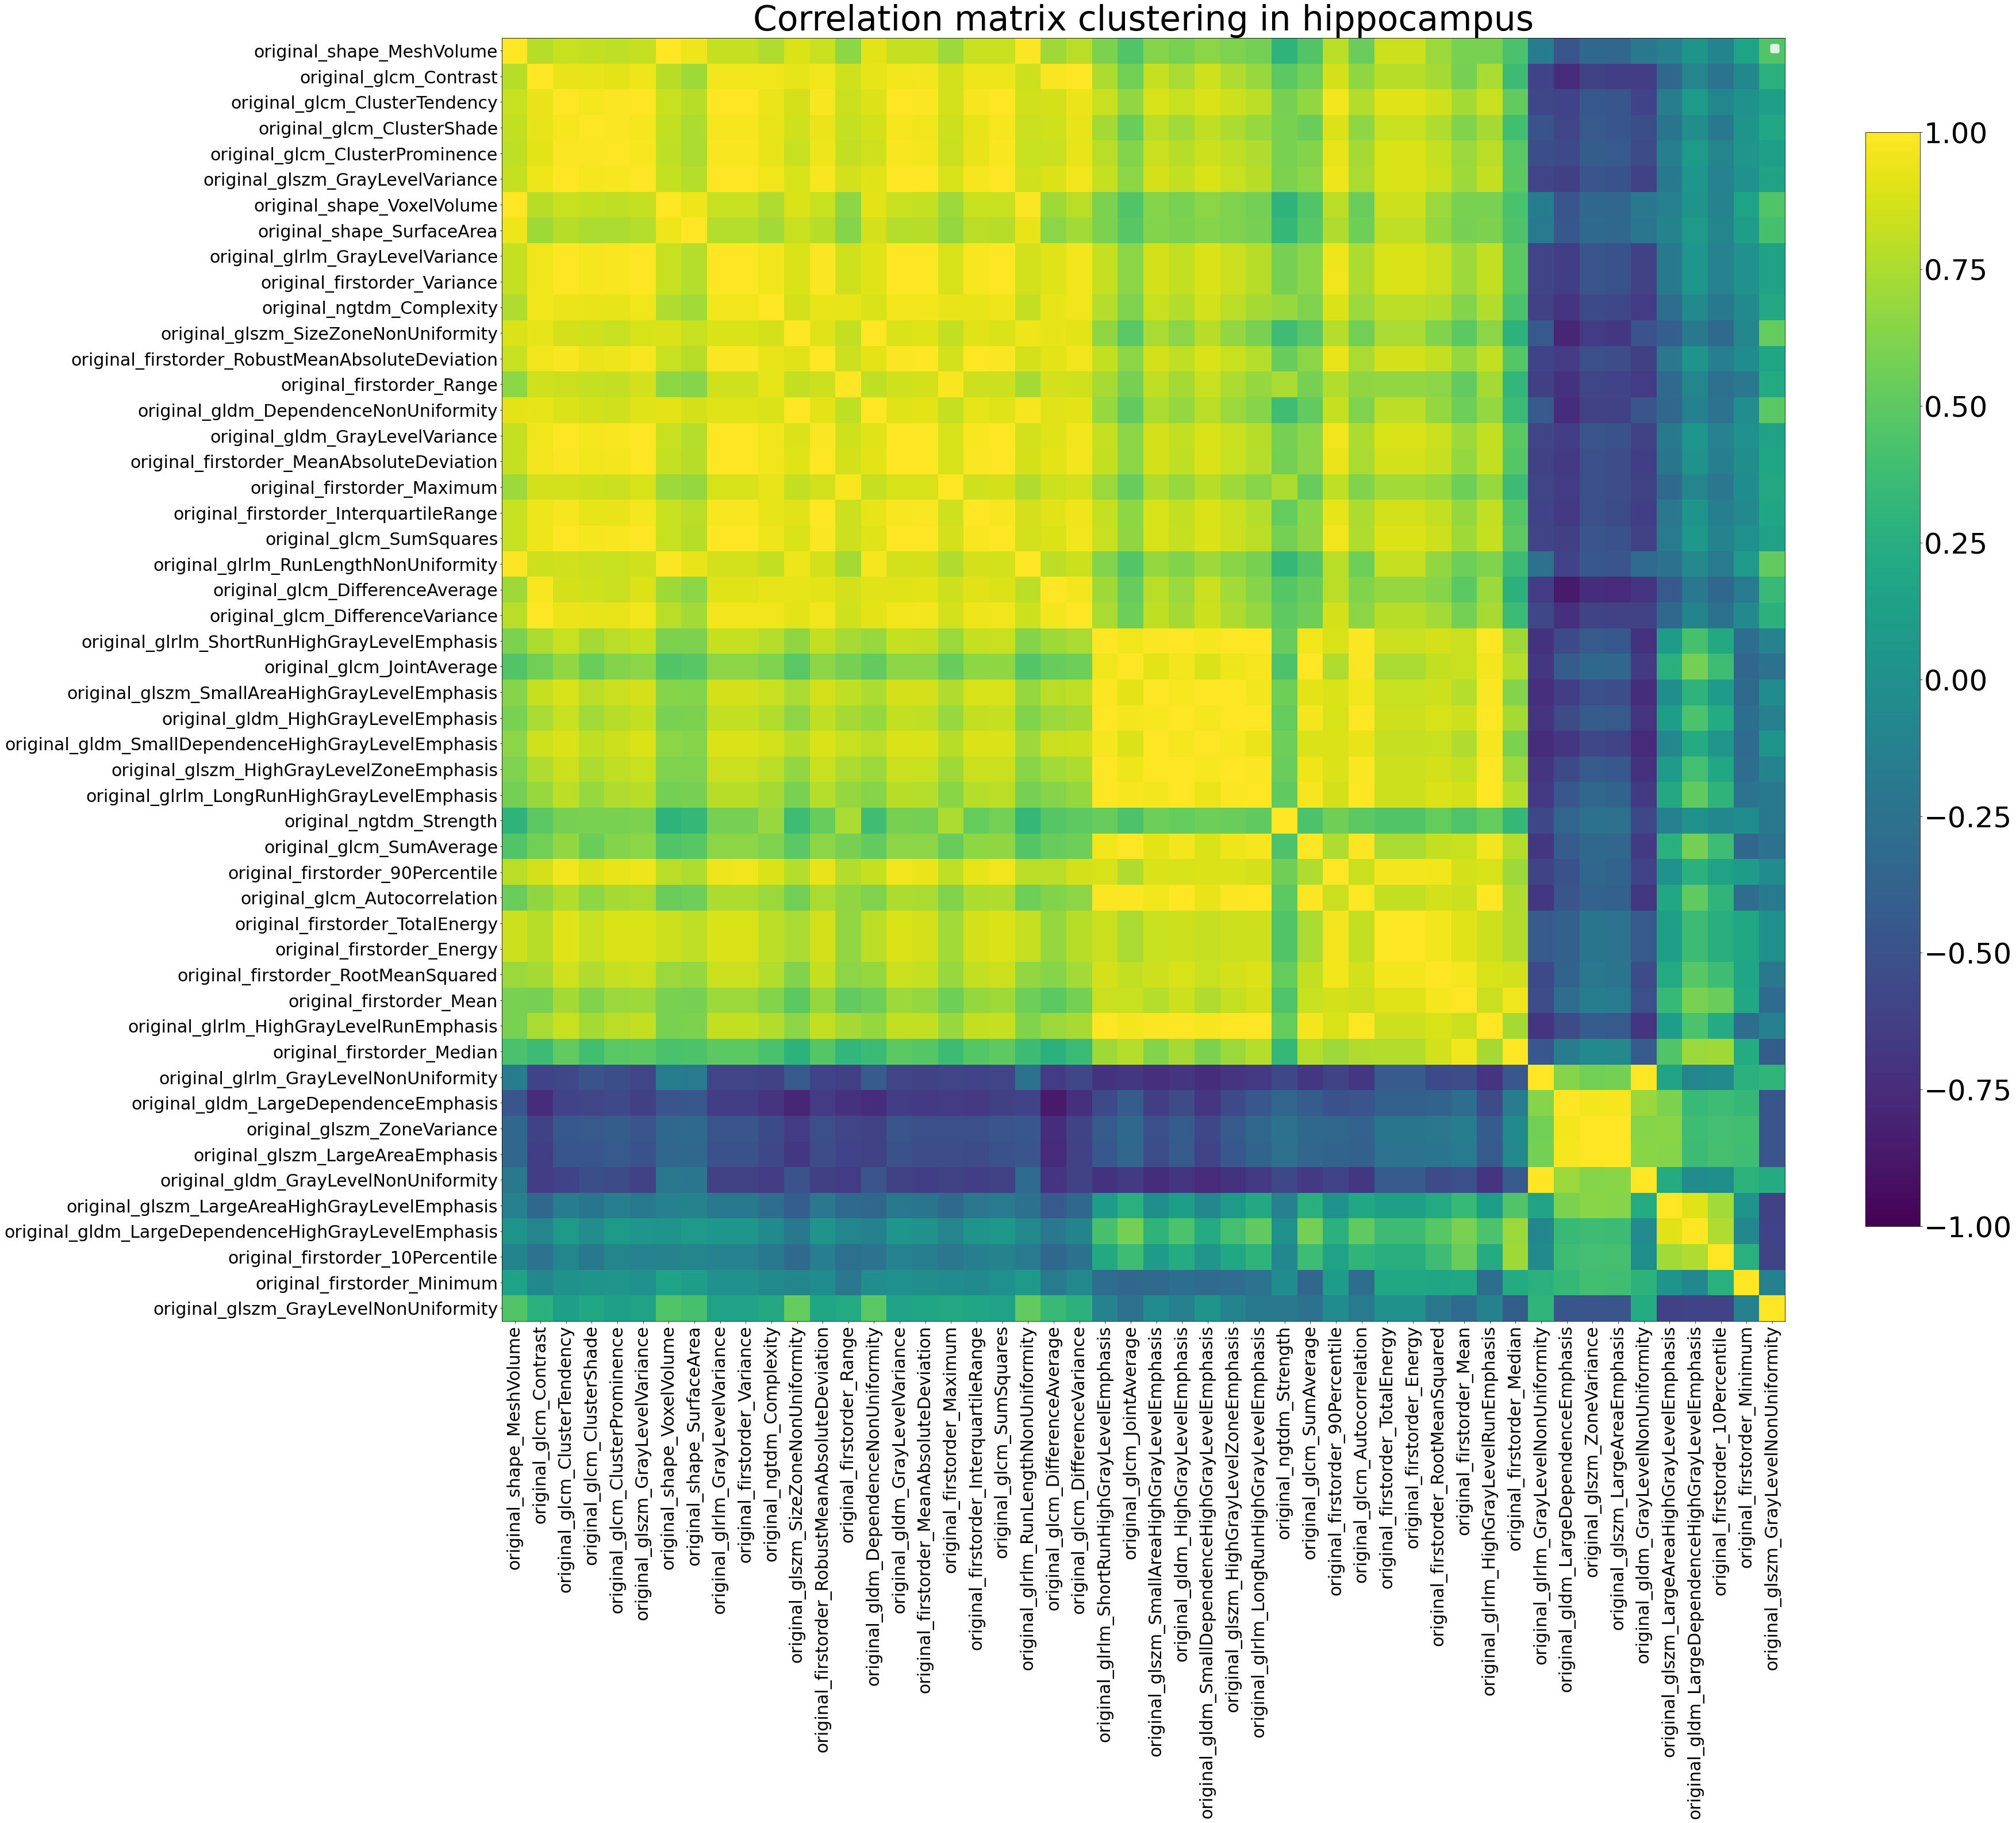

In [18]:
#Here we reorganise the features according to the cluster they belong to. 
columns = [base_dades_features.columns.tolist()[i] for i in list((np.argsort(idx)))]
base_dades_features = base_dades_features.reindex(columns, axis=1)

plt.figure(figsize=(50, 50))
cmc = plt.imshow(base_dades_features.corr())
cbar = plt.colorbar(cmc, anchor=(0, 0.3), shrink=0.7)
cbar.ax.tick_params(labelsize=50)
plt.clim(-1.00, 1.00)
plt.title('Correlation matrix clustering in hippocampus', fontsize = 60)
plt.xticks(range(len(base_dades_features.columns)), base_dades_features.columns, rotation=90, fontsize = 30)
plt.yticks(range(len(base_dades_features.columns)), base_dades_features.columns, fontsize = 30)
plt.legend(fontsize=20)
plt. savefig('/Users/elisabetsorribes/Desktop/TFG/ALL DATASETS/correlationclusteringhippo.png')

In [19]:
#Here we will create a list for each cluster in order to store all the characteristics by which they are formed.  
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []

for i in range(len(features_remaining)):
    
    num_cluster = idx[i]
    feature = features_remaining[i]
    
    if (num_cluster == 1):
        cluster1.append(feature)
        
    elif (num_cluster == 2):
        cluster2.append(feature)
    
    elif (num_cluster == 3):
        cluster3.append(feature)
    
    elif (num_cluster == 4):
        cluster4.append(feature)
    
    else:
        cluster5.append(feature)
    
print(cluster1)
(" ")
print(cluster2)
(" ")
print(cluster3)
(" ")
print(cluster4)
(" ")
print(cluster5)
(" ")

['original_firstorder_InterquartileRange', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_Variance', 'original_shape_MeshVolume', 'original_shape_SurfaceArea', 'original_shape_VoxelVolume', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_ClusterTendency', 'original_glcm_Contrast', 'original_glcm_DifferenceAverage', 'original_glcm_DifferenceVariance', 'original_glcm_SumSquares', 'original_glrlm_GrayLevelVariance', 'original_glrlm_RunLengthNonUniformity', 'original_glszm_GrayLevelVariance', 'original_glszm_SizeZoneNonUniformity', 'original_gldm_DependenceNonUniformity', 'original_gldm_GrayLevelVariance', 'original_ngtdm_Complexity']
['original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_RootMeanSquared', 'original_firstorder_TotalEnergy', 

' '

**Cluster 1:**
- 'original_firstorder_InterquartileRange', 
- 'original_firstorder_Maximum', 
- 'original_firstorder_MeanAbsoluteDeviation', 
- 'original_firstorder_Range', 
- 'original_firstorder_RobustMeanAbsoluteDeviation', 
- 'original_firstorder_Variance', 
- 'original_shape_MeshVolume', 
- 'original_shape_SurfaceArea', 
- 'original_shape_VoxelVolume', 
- 'original_glcm_ClusterProminence', 
- 'original_glcm_ClusterShade', 
- 'original_glcm_ClusterTendency', 
- 'original_glcm_Contrast', 
- 'original_glcm_DifferenceAverage', 
- 'original_glcm_DifferenceVariance', 
- 'original_glcm_SumSquares', 
- 'original_glrlm_GrayLevelVariance', 
- 'original_glrlm_RunLengthNonUniformity', 
- 'original_glszm_GrayLevelVariance', 
- 'original_glszm_SizeZoneNonUniformity', 
- 'original_gldm_DependenceNonUniformity', 
- 'original_gldm_GrayLevelVariance', 
- 'original_ngtdm_Complexity'

In [20]:
def get_feature_cluster1(i):
    switcher={
        0: matriu_original_firstorder_InterquartileRange,
        1: matriu_original_firstorder_Maximum,
        2: matriu_original_firstorder_MeanAbsoluteDeviation,
        3: matriu_original_firstorder_Range,
        4: matriu_original_firstorder_RobustMeanAbsoluteDeviation,
        5: matriu_original_firstorder_Variance,
        6: matriu_original_shape_MeshVolume,
        7: matriu_original_shape_SurfaceArea,
        8: matriu_original_shape_VoxelVolume,
        9: matriu_original_glcm_ClusterProminence,
        10: matriu_original_glcm_ClusterShade,
        11: matriu_original_glcm_ClusterTendency,
        12: matriu_original_glcm_Contrast,
        13: matriu_original_glcm_DifferenceAverage,
        14: matriu_original_glcm_DifferenceVariance,
        15: matriu_original_glcm_SumSquares,
        16: matriu_original_glrlm_GrayLevelVariance,
        17: matriu_original_glrlm_RunLengthNonUniformity,
        18: matriu_original_glszm_GrayLevelVariance,
        19: matriu_original_glszm_SizeZoneNonUniformity,
        20: matriu_original_gldm_DependenceNonUniformity,
        21: matriu_original_gldm_GrayLevelVariance,
        22: matriu_original_ngtdm_Complexity, 
    }
    return switcher.get(i)

**Cluster 2:**
- 'original_firstorder_90Percentile', 
- 'original_firstorder_Energy', 
- 'original_firstorder_Mean', 
- 'original_firstorder_Median', 
- 'original_firstorder_RootMeanSquared', 
- 'original_firstorder_TotalEnergy', 
- 'original_glcm_Autocorrelation', 
- 'original_glcm_JointAverage', 
- 'original_glcm_SumAverage', 
- 'original_glrlm_HighGrayLevelRunEmphasis', 
- 'original_glrlm_LongRunHighGrayLevelEmphasis', 
- 'original_glrlm_ShortRunHighGrayLevelEmphasis', 
- 'original_glszm_HighGrayLevelZoneEmphasis', 
- 'original_glszm_SmallAreaHighGrayLevelEmphasis', 
- 'original_gldm_HighGrayLevelEmphasis', 
- 'original_gldm_SmallDependenceHighGrayLevelEmphasis', 
- 'original_ngtdm_Strength'

In [21]:
def get_feature_cluster2(i):
    switcher={
        0: matriu_original_firstorder_90Percentile,
        1: matriu_original_firstorder_Energy,
        2: matriu_original_firstorder_Mean,
        3: matriu_original_firstorder_Median,
        4: matriu_original_firstorder_RootMeanSquared,
        5: matriu_original_firstorder_TotalEnergy,
        6: matriu_original_glcm_Autocorrelation,
        7: matriu_original_glcm_JointAverage,
        8: matriu_original_glcm_SumAverage,
        9: matriu_original_glrlm_HighGrayLevelRunEmphasis,
        10: matriu_original_glrlm_LongRunHighGrayLevelEmphasis,
        11: matriu_original_glrlm_ShortRunHighGrayLevelEmphasis,
        12: matriu_original_glszm_HighGrayLevelZoneEmphasis,
        13: matriu_original_glszm_SmallAreaHighGrayLevelEmphasis,
        14: matriu_original_gldm_HighGrayLevelEmphasis,
        15: matriu_original_gldm_SmallDependenceHighGrayLevelEmphasis,
        16: matriu_original_ngtdm_Strength,
    }
    return switcher.get(i)

**Cluster 3:**
- 'original_glrlm_GrayLevelNonUniformity',
- 'original_glszm_LargeAreaEmphasis', 
- 'original_glszm_ZoneVariance', 
- 'original_gldm_GrayLevelNonUniformity', 
- 'original_gldm_LargeDependenceEmphasis'

In [22]:
def get_feature_cluster3(i):
    switcher={
        0: matriu_original_glrlm_GrayLevelNonUniformity,
        1: matriu_original_glszm_LargeAreaEmphasis,
        2: matriu_original_glszm_ZoneVariance,
        3: matriu_original_gldm_GrayLevelNonUniformity,
        4: matriu_original_gldm_LargeDependenceEmphasis,
    }
    return switcher.get(i)

**Cluster 4:**
- 'original_firstorder_10Percentile', 
- 'original_glszm_LargeAreaHighGrayLevelEmphasis', 
- 'original_gldm_LargeDependenceHighGrayLevelEmphasis'

In [23]:
def get_feature_cluster4(i):
    switcher={
        0: matriu_original_firstorder_10Percentile,
        1: matriu_original_glszm_LargeAreaHighGrayLevelEmphasis,
        2: matriu_original_gldm_LargeDependenceHighGrayLevelEmphasis,
    }
    return switcher.get(i)

**Cluster 5:**
- 'original_firstorder_Minimum', 
- 'original_glszm_GrayLevelNonUniformity'

In [24]:
def get_feature_cluster5(i):
    switcher={
        0: matriu_original_firstorder_Minimum,
        1: matriu_original_glszm_GrayLevelNonUniformity,
    }
    return switcher.get(i)

In [25]:
num_avaluacions = len(casos)
#In the matrices below we will store the values of the characteristics by which the cluster is formed. 

select_cluster1 = np.zeros((num_avaluacions, len(cluster1))) 
select_cluster2 = np.zeros((num_avaluacions, len(cluster2)))
select_cluster3 = np.zeros((num_avaluacions, len(cluster3)))
select_cluster4 = np.zeros((num_avaluacions, len(cluster4)))
select_cluster5 = np.zeros((num_avaluacions, len(cluster5)))

In [26]:
#If computed the binary classification: output between CTR (0) and Tg (1)
y_ADcontrol = []

for i in range(num_avaluacions):
    
    if (0 <= i < 140): #The first 140 cases are control, so y=0.
        y_ADcontrol.append(0)
    else: 
        y_ADcontrol.append(1) #Tg cases
        
print(y_ADcontrol)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [27]:
#If computed the multi-class classification: output between Young-CTR(0), Old-CTR(1), Young-Tg(2), Old-Tg(3)

#y_ADcontrol = []
#comptador = 0

#for i in range(num_avaluacions):
    
    #if (comptador == 5):
        #comptador = 0
    
    #if (0 <= i < 140): #The first 140 cases are control
        #if (comptador == 0) or (comptador == 1) or (comptador == 2): 
            #y_ADcontrol.append(0) #Young-CTR
            #comptador += 1
        #else:
            #y_ADcontrol.append(1) #Old-CTR
            #comptador += 1
    #else: 
        #if (comptador == 0) or (comptador == 1) or (comptador == 2):
            #y_ADcontrol.append(2) #Young-Tg
            #comptador += 1
        #else:
            #y_ADcontrol.append(3) #Old-Tg
            #comptador += 1
        
#print(y_ADcontrol)

In [28]:
#SelectFromModel Cluster 1

for i in range(len(cluster1)): 
    
    matriu = get_feature_cluster1(i)
    comptador = 0
    
    for case in range(len(matriu)):
        for temps in range(num_temps):
            valor = matriu[case][temps]
            select_cluster1[comptador][i] = valor #Here, we store each feature value to select_cluster1 matrix. 
            comptador = comptador + 1

select_cluster1 = np.nan_to_num(select_cluster1)
print(select_cluster1[0])

#Selector 
selector_ADcontrol = SelectFromModel(estimator=LogisticRegression()).fit(select_cluster1, y_ADcontrol) 
selector_ADcontrol.estimator_.coef_
selector_ADcontrol.threshold_
selector_ADcontrol.get_support()
output_c1 = selector_ADcontrol.transform(select_cluster1) #In output_c1, it will be stored the selected feature(s).
print(output_c1)

[1.60474750e+02 9.95823444e+02 1.05240670e+02 1.02128778e+03
 6.77781536e+01 1.93738777e+04 9.99163333e+01 2.72371368e+02
 1.00808000e+02 3.55761602e+07 1.52386557e+05 2.44055615e+03
 3.05314102e+02 1.25659206e+01 1.44006110e+02 6.86467563e+02
 7.82304792e+02 1.15978255e+04 8.75345033e+02 5.32849590e+03
 4.84630609e+03 7.74837868e+02 1.44386826e+05]
[[152386.55664863  11597.82551934]
 [ 81616.22959443  13485.12064405]
 [186960.33135604  14416.03536356]
 [115893.46448495  14069.78377565]
 [180919.17636223  14342.05335466]
 [134698.86608506  11388.15393573]
 [239095.60759571  15285.63291476]
 [130582.86292692  13744.82935765]
 [192510.64574124  14594.7168097 ]
 [233062.33590565  16723.26672383]
 [176733.47475474  14093.17807779]
 [234777.28611779  14235.75143876]
 [173938.08854557  15364.46295644]
 [-29420.19342243   9990.36245142]
 [182440.18966725  17279.31301887]
 [209673.56888738  12710.62838025]
 [278531.74745003  13173.08784193]
 [     0.              0.        ]
 [     0.         

In [29]:
#SelectFromModel Cluster 2 

for i in range(len(cluster2)): 
    
    matriu = get_feature_cluster2(i)
    comptador = 0
    
    for case in range(len(matriu)):
        for temps in range(num_temps):
            valor = matriu[case][temps]
            select_cluster2[comptador][i] = valor
            comptador = comptador + 1

select_cluster2 = np.nan_to_num(select_cluster2)
print(select_cluster2[0])

#Selector 
selector_ADcontrol = SelectFromModel(estimator=LogisticRegression()).fit(select_cluster2, y_ADcontrol) 
selector_ADcontrol.estimator_.coef_
selector_ADcontrol.threshold_
selector_ADcontrol.get_support()
output_c2 = selector_ADcontrol.transform(select_cluster2)
print(output_c2)

[4.69884130e+02 1.36540639e+09 2.98300367e+02 2.72383043e+02
 3.29176224e+02 1.09232511e+07 4.65955373e+03 6.42301775e+01
 1.28460355e+02 5.18730805e+03 5.53618119e+03 5.10499606e+03
 5.63544836e+03 4.77188881e+03 5.15258035e+03 3.57204004e+03
 2.17904417e+01]
[[1.36540639e+09]
 [8.77242760e+08]
 [1.33761773e+09]
 [1.31978541e+09]
 [1.33792568e+09]
 [1.64183853e+09]
 [1.81443733e+09]
 [1.20515061e+09]
 [1.52360058e+09]
 [1.83255787e+09]
 [1.70334150e+09]
 [1.58344900e+09]
 [1.33524793e+09]
 [2.10195766e+09]
 [1.68910030e+09]
 [1.51391534e+09]
 [1.69440643e+09]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.40949960e+09]
 [1.95343325e+09]
 [1.18832652e+09]
 [1.59890012e+09]
 [1.40458908e+09]
 [1.85630793e+09]
 [1.84882495e+09]
 [0.00000000e+00]
 [2.94026792e+09]
 [2.34688932e+09]
 [6.83761320e+08]
 [6.95684258e+08]
 [6.58130238e+08]
 [7.62622852e+08]
 [0.00000000e+00]
 [6.93633677e+08]
 [6.89148838e+08]
 [7.56744002e+08]
 [6.63435750e+08]
 [0.00000000e+00]
 [7.52214306e+08]
 

In [30]:
#SelectFromModel Cluster 3 

for i in range(len(cluster3)): 
    
    matriu = get_feature_cluster3(i)
    comptador = 0
    
    for case in range(len(matriu)): 
        for temps in range(num_temps):
            valor = matriu[case][temps]
            select_cluster3[comptador][i] = valor
            comptador = comptador + 1

select_cluster3 = np.nan_to_num(select_cluster3)
print(select_cluster3[0])

#Selector
selector_ADcontrol = SelectFromModel(estimator=LogisticRegression()).fit(select_cluster3, y_ADcontrol)
selector_ADcontrol.estimator_.coef_
selector_ADcontrol.threshold_
selector_ADcontrol.get_support()
output_c3 = selector_ADcontrol.transform(select_cluster3)
print(output_c3)

[146.74781628   3.39637483   1.33283537 152.28672328   3.91389572]
[[ 3.91389572]
 [ 3.48084872]
 [ 3.22331926]
 [ 3.25662131]
 [ 3.28442997]
 [ 3.18005426]
 [ 3.06328725]
 [ 3.12940213]
 [ 3.20093608]
 [ 3.22081701]
 [ 3.11420205]
 [ 3.0916101 ]
 [ 3.20252085]
 [13.68865884]
 [ 3.23204719]
 [ 2.91187597]
 [ 2.99914304]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 2.88141142]
 [ 2.87183384]
 [ 2.98799069]
 [ 2.89247593]
 [ 3.14069023]
 [ 3.03190248]
 [ 2.93035597]
 [ 0.        ]
 [ 2.88297528]
 [ 3.2416562 ]
 [ 4.89098081]
 [ 4.59313494]
 [ 4.98315024]
 [ 4.43072482]
 [ 0.        ]
 [ 4.13403293]
 [ 5.03009769]
 [ 4.2998155 ]
 [ 4.88289702]
 [ 0.        ]
 [ 4.0750121 ]
 [ 4.57552147]
 [ 4.58480149]
 [ 4.4881078 ]
 [ 0.        ]
 [ 4.3925104 ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 4.13139505]
 [ 0.        ]
 [ 5.2121185 ]
 [ 0.        ]
 [ 0.        ]
 [ 4.30340635]
 [ 4.56858263]
 [ 4.89540412]
 [ 4.30577198]
 [ 0.        ]
 [ 4.10078805]
 [ 0.        ]
 [ 

In [31]:
#SelectFromModel Cluster 4 

for i in range(len(cluster4)): 
    
    matriu = get_feature_cluster4(i)
    comptador = 0
    
    for case in range(len(matriu)): 
        for temps in range(num_temps):
            valor = matriu[case][temps]
            select_cluster4[comptador][i] = valor
            comptador = comptador + 1

select_cluster4 = np.nan_to_num(select_cluster4)
print(select_cluster4[0])

#Selector 
selector_ADcontrol = SelectFromModel(estimator=LogisticRegression()).fit(select_cluster4, y_ADcontrol) 
selector_ADcontrol.estimator_.coef_
selector_ADcontrol.threshold_
selector_ADcontrol.get_support()
output_c4 = selector_ADcontrol.transform(select_cluster4)
print(output_c4)

[  144.64687896 14307.62870497 16170.84572653]
[[144.64687896]
 [ 89.100817  ]
 [ 82.11728473]
 [ 93.42129229]
 [ 85.33553312]
 [156.75803841]
 [103.68440672]
 [ 87.52383437]
 [ 94.72086006]
 [ 88.78211146]
 [116.65501286]
 [ 98.67920604]
 [ 92.62833683]
 [247.38405717]
 [ 86.82737959]
 [114.22641142]
 [102.85802449]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [ 96.10662639]
 [108.19484447]
 [ 86.88369031]
 [ 83.60939052]
 [ 83.13024315]
 [112.14179527]
 [ 91.57674003]
 [  0.        ]
 [ 82.93730375]
 [ 71.94361122]
 [113.44985437]
 [ 91.49230402]
 [ 83.10813311]
 [ 77.31725306]
 [  0.        ]
 [ 94.08633585]
 [121.37160841]
 [107.67615837]
 [ 91.4579121 ]
 [  0.        ]
 [ 93.02316546]
 [ 93.53300063]
 [ 91.57286359]
 [ 86.10956391]
 [  0.        ]
 [106.72204809]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [ 98.50112198]
 [  0.        ]
 [105.39694046]
 [  0.        ]
 [  0.        ]
 [100.16549577]
 [ 88.06629373]
 [100.51844541]
 [ 83.44455424]
 [  0.   

In [32]:
#SelectFromModel Cluster 5

for i in range(len(cluster5)): 
    
    matriu = get_feature_cluster5(i)
    comptador = 0
    
    for case in range(len(matriu)):
        for temps in range(num_temps):
            valor = matriu[case][temps]
            select_cluster5[comptador][i] = valor
            comptador = comptador + 1

select_cluster5 = np.nan_to_num(select_cluster5)
print(select_cluster5[0])

#Selector 
selector_ADcontrol = SelectFromModel(estimator=LogisticRegression()).fit(select_cluster5, y_ADcontrol) 
selector_ADcontrol.estimator_.coef_
selector_ADcontrol.threshold_
selector_ADcontrol.get_support()
output_c5 = selector_ADcontrol.transform(select_cluster5)
print(output_c5)

[-25.46433431  95.51504788]
[[ 95.51504788]
 [136.39092212]
 [117.66747238]
 [114.90512062]
 [116.58050662]
 [ 87.99034876]
 [115.17595734]
 [116.63239538]
 [113.36362073]
 [123.42088749]
 [107.20084567]
 [110.07960589]
 [136.21302113]
 [ 57.8653898 ]
 [134.07404441]
 [ 98.68894009]
 [ 94.27892427]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [104.90923642]
 [107.46003581]
 [105.25596402]
 [110.81539498]
 [108.65881814]
 [106.11488783]
 [117.44120595]
 [  0.        ]
 [106.5185594 ]
 [116.07172813]
 [102.83328873]
 [116.66063138]
 [107.2618137 ]
 [103.88148919]
 [  0.        ]
 [106.69128811]
 [109.09545455]
 [ 91.61201016]
 [108.41696024]
 [  0.        ]
 [109.89666893]
 [109.23334508]
 [113.9263308 ]
 [105.37058963]
 [  0.        ]
 [ 95.46945253]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.        ]
 [108.58533876]
 [  0.        ]
 [106.14542438]
 [  0.        ]
 [  0.        ]
 [108.90361446]
 [102.89332063]
 [100.4168215 ]
 [102.43592099]
 [  0.        ]
 [109.158236

Features selected in binary classification (6 features in total):
- original_glcm_ClusterShade 
- original_glrlm_RunLengthNonUniformity 
- original_firstorder_Energy 
- original_gldm_LargeDependenceEmphasis 
- original_firstorder_10Percentile 
- original_glszm_GrayLevelNonUniformity 

Features selected in multi-class classification (6 features in total):
- original_glcm_ClusterShade 
- original_ngtdm_Complexity 
- original_firstorder_Energy 
- original_gldm_LargeDependenceEmphasos 
- original_firstorder_10Percentile 
- original_firstorder_Minimum 

In [33]:
def get_cluster(i):
    switcher={
        0: output_c1, #2 features selected
        1: output_c2,
        2: output_c3,
        3: output_c4,
        4: output_c5
    }
    return switcher.get(i)

In [34]:
#Here we will fill in the matrix we will use for machine learning, with the values of the selected features. 

#If age considered, dimensionality (num_avaluacions,7). If not, (num_avaluacions,6)

matriu_machine_max = np.zeros((num_avaluacions, 7)) 
comptador = 0

for i in range(5):
    cluster = get_cluster(i)
    dim = cluster.shape[1]
    
    for num in range(dim):
        for aval in range(num_avaluacions):
            valor = cluster[aval][num]
            
            if (valor==0.0):
                valor = np.nan
                
            matriu_machine_max[aval][comptador] = valor
        
        comptador = comptador + 1

#Here, we will fill the last column with age, if considered. 

age = [160, 232, 344, 447, 541, #3077
       140, 231, 343, 448, 544, #3078
       170, 240, 337, 459, 541, #3121
       156, 246, np.nan, np.nan, np.nan, #3536
       160, 247, 336, 436, 526, #3542
       162, 247, np.nan, 436, 526, #3544
       92, 212, 336, 463, np.nan, #4979
       88, 213, 333, 452, np.nan, #4996
       88, 213, 333, 452, np.nan, #4998
       94, np.nan, np.nan, np.nan, np.nan, #5007
       94, np.nan, 333, np.nan, np.nan, #5009
       96, 211, 331, 451, np.nan, #5013
       96, np.nan, np.nan, np.nan, np.nan, #5014
       116, 219, 339, 456, np.nan, #5021
       94, np.nan, np.nan, np.nan, np.nan, #5042
       94, np.nan, 341, np.nan, np.nan, #5056
       94, np.nan, 341, np.nan, np.nan, #5057
       92, np.nan, np.nan, np.nan, np.nan, #5063
       92, np.nan, np.nan, np.nan, np.nan, #5064
       92, np.nan, np.nan, np.nan, np.nan, #5065
       93, np.nan, np.nan, np.nan, np.nan, #5066
       91, np.nan, np.nan, np.nan, np.nan, #5086
       91, np.nan, np.nan, np.nan, np.nan, #5087
       92, 210, np.nan, np.nan, np.nan, #5097
       94, 211, 330, np.nan, np.nan, #5102
       95, 211, 330, np.nan, np.nan, #5104
       91, np.nan, np.nan, np.nan, np.nan, #5113
       91, np.nan, np.nan, np.nan, np.nan, #5114
       140, 246, 344, 447, 541, #3076
       149, 260, 338, 458, np.nan, #3148
       181, 261, 338, 443, np.nan, #3171
       200, 258, 341, 445, 559, #3265
       226, 261, 340, 446, np.nan, #3289
       np.nan, np.nan, 332, 445, 559, #3457
       87, 235, 336, 450, np.nan, #4970
       87, 217, 336, 450, np.nan, #4971
       91, np.nan, np.nan, np.nan, np.nan, #4978
       92, np.nan, np.nan, np.nan, np.nan, #4985
       92, np.nan, np.nan, np.nan, np.nan, #4986
       95, 212, 332, 463, np.nan, #4993
       88, 215, 320, 454, np.nan, #4997
       94, 211, 331, np.nan, np.nan, #5008
       115, 218, 332, 451, np.nan, #5020
       93, np.nan, 365, np.nan, np.nan, #5032
       93, np.nan, 365, np.nan, np.nan, #5033
       93, np.nan, np.nan, np.nan, np.nan, #5034
       94, 211, 365, np.nan, np.nan, #5041
       91, np.nan, np.nan, np.nan, np.nan, #5058
       92, 210, np.nan, np.nan, np.nan, #5098
       94, 211, 330, np.nan, np.nan, #5103
       95, 213, 332, np.nan, np.nan, #5105
       103, np.nan, np.nan, np.nan, np.nan] #5378
       
for i in range(len(age)):
    age_value = age[i]
    matriu_machine_max[i][6] = age_value

datapath = '/Users/elisabetsorribes/Desktop/TFG/ALL DATASETS/matrizfeaturesmachineambnanmax.csv'
with open(datapath, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(matriu_machine_max)

In [35]:
#Names for binary classification.
names = ['original_glcm_ClusterShade','original_glrlm_RunLengthNonUniformity', 'original_firstorder_Energy', 
         'original_gldm_LargeDependenceEmphasis','original_firstorder_10Percentile','original_glszm_GrayLevelNonUniformity', 
         'age']

#Names for multi-class classification.
#names = ['original_glcm_ClusterShade','original_ngtdm_Complexity', 'original_firstorder_Energy', 
#         'original_gldm_LargeDependenceEmphasis','original_firstorder_10Percentile','original_firstorder_Minimum', 
#         'age']

#Finally, we create the first dataset from which the classification models will be trained and tested through 
#the Stratified K-Fold Cross-validation.

dataset_first = pd.DataFrame(data=matriu_machine_max, columns=names) 
print(dataset_first)

datapath = '/Users/elisabetsorribes/Desktop/TFG/ALL DATASETS/datasetprimer.csv'
dataset_first.to_csv(datapath, header=names)

     original_glcm_ClusterShade  original_glrlm_RunLengthNonUniformity  \
0                 152386.556649                           11597.825519   
1                  81616.229594                           13485.120644   
2                 186960.331356                           14416.035364   
3                 115893.464485                           14069.783776   
4                 180919.176362                           14342.053355   
..                          ...                                    ...   
255                45269.477450                           11434.512160   
256                         NaN                                    NaN   
257                         NaN                                    NaN   
258                         NaN                                    NaN   
259                         NaN                                    NaN   

     original_firstorder_Energy  original_gldm_LargeDependenceEmphasis  \
0                  1.365406e+09      

## Machine learning 

### Preparation of the main dataset (training and test sets)

In [36]:
#Load dataset 

datapath = '/Users/elisabetsorribes/Desktop/TFG/ALL DATASETS/datasetprimer.csv'
dataset_first = read_csv(datapath)

#It is created "case + timeframe" indices.

index_temps_train = []

for i in nom_carpetes_train:
    cas = str(i)
    for j in range(len(nom_temps)):
        temps = nom_temps[j]
        cas = cas + ' ' + str(temps)
        index_temps_train.append(cas)
        cas = str(i)

In [37]:
#We eliminate the rows of the matrix machine that have nan. 

nan_rows = dataset_first[dataset_first.isnull().any(1)]
num_files_train = []

for fila in range(len(nan_rows)):
    valor = nan_rows.index[fila]
    num_files_train.append(valor)

dataset_first = dataset_first.drop(index=num_files_train) 
#print(len(dataset_first))
matriu_dataset_first = dataset_first.to_numpy()

datapath = '/Users/elisabetsorribes/Desktop/TFG/ALL DATASETS/datasett1t2t3t4t5net.csv'
with open(datapath, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(matriu_dataset_first)

In [38]:
index_temps_train = np.delete(index_temps_train, num_files_train)
print(index_temps_train)

['3077 t1' '3077 t2' '3077 t3' '3077 t4' '3077 t5' '3078 t1' '3078 t2'
 '3078 t3' '3078 t4' '3078 t5' '3121 t1' '3121 t2' '3121 t3' '3121 t4'
 '3121 t5' '3536 t1' '3536 t2' '3542 t1' '3542 t2' '3542 t3' '3542 t4'
 '3542 t5' '3544 t1' '3544 t2' '3544 t4' '3544 t5' '4979 t1' '4979 t2'
 '4979 t3' '4979 t4' '4996 t1' '4996 t2' '4996 t3' '4996 t4' '4998 t1'
 '4998 t2' '4998 t3' '4998 t4' '5007 t1' '5009 t1' '5009 t3' '5013 t1'
 '5013 t2' '5013 t3' '5013 t4' '5014 t1' '5021 t1' '5021 t2' '5021 t3'
 '5021 t4' '5042 t1' '5056 t1' '5056 t3' '5057 t1' '5057 t3' '5063 t1'
 '5064 t1' '5065 t1' '5066 t1' '5086 t1' '5087 t1' '5097 t1' '5097 t2'
 '5102 t1' '5102 t2' '5102 t3' '5104 t1' '5104 t2' '5104 t3' '5113 t1'
 '5114 t1' '3076 t1' '3076 t2' '3076 t3' '3076 t4' '3076 t5' '3148 t1'
 '3148 t2' '3148 t3' '3148 t4' '3171 t1' '3171 t2' '3171 t3' '3171 t4'
 '3265 t1' '3265 t2' '3265 t3' '3265 t4' '3265 t5' '3289 t1' '3289 t2'
 '3289 t3' '3289 t4' '3457 t3' '3457 t4' '3457 t5' '4970 t1' '4970 t2'
 '4970

### Preparation of the validation dataset 

In [39]:
nom_carpetes_validation = [3079, 3329, 3543, 4972, 4980, 5018, 3157, 3164, 3288, 4987, 4994, 5019] 
num_casos_validation = len(nom_carpetes_validation) #12 cases
nom_temps = ['t1', 't2', 't3', 't4', 't5']
num_temps = len(nom_temps)
num_avaluacions = num_casos_validation*num_temps

counter_firstorder = 18
counter_shape = 14
counter_glcm = 24
counter_glrlm = 16
counter_glszm = 16
counter_gldm = 14
counter_ngtdm = 5

matriu = np.zeros((num_avaluacions, num_total_features)) #(60,107)

fitxers_features = ['firstordertot.csv', 'shapetot.csv', 'glcmtot.csv', 'gldmtot.csv', 'glrlmtot.csv', 'glszmtot.csv', 'ngtdmtot.csv']
path_ = "/Users/elisabetsorribes/Desktop/TFG/ALL DATASETS/"

In [40]:
#Here, we will create a matrix with all radiomic features values.

for i in range(num_casos_validation):
    for temps in nom_temps:
        carpeta = nom_carpetes_validation[i]
        path_1 = str(carpeta) + "/" + temps
        data_path = os.path.join(path_,path_1)
        
        if (i==0) and (temps == 't1'):
            fila = 0
        else:
            fila = fila + 1
        
        if os.path.isdir(data_path):
            for fitxer in fitxers_features:
                path_def = data_path + "/" + str(fitxer)
                
                with open(path_def) as Features: 
                    reader = csv.reader(Features, delimiter=',', quotechar=',', quoting=csv.QUOTE_MINIMAL)
                    contador = 0 
                    for row in reader:
                        contador = contador + 1
                    
                        if contador%2 == 0: #We have a counter for the pairs because they are the ones that contain the values of the feature.
                        
                            if 'firstordertot.csv' in path_def: #It has 18 features
                                for feat in range (counter_firstorder):
                                    valor = row[feat]
                                    matriu[fila][feat] = valor
                            
                            if 'shapetot.csv' in path_def: #It has 14 features
                                comptador_shape = 18
                            
                                for feat2 in range (counter_shape):
                                    valor = row[feat2]
                                    matriu[fila][comptador_shape] = valor
                                    comptador_shape = comptador_shape + 1
                            
                            if 'glcmtot.csv' in path_def: #It has 24 features
                                comptador_glcm = comptador_shape
                            
                                for feat3 in range (counter_glcm):
                                    valor = row[feat3]
                                    matriu[fila][comptador_glcm] = valor
                                    comptador_glcm = comptador_glcm + 1
                        
                            if 'gldmtot.csv' in path_def: #It has 14 features
                                comptador_gldm = comptador_glcm
                            
                                for feat4 in range (counter_gldm):
                                    valor = row[feat4]
                                    matriu[fila][comptador_gldm] = valor
                                    comptador_gldm = comptador_gldm + 1
                            
                            if 'glrlmtot.csv' in path_def: #It has 16 features
                                comptador_glrlm = comptador_gldm
                            
                                for feat5 in range (counter_glrlm):
                                    valor = row[feat5]
                                    matriu[fila][comptador_glrlm] = valor
                                    comptador_glrlm = comptador_glrlm + 1
                        
                            if 'glszmtot.csv' in path_def: #It has 16 features
                                comptador_glszm = comptador_glrlm
                            
                                for feat6 in range (counter_glszm):
                                    valor = row[feat6]
                                    matriu[fila][comptador_glszm] = valor
                                    comptador_glszm = comptador_glszm + 1
                        
                            if 'ngtdmtot.csv' in path_def: #It has 5 features
                                comptador_ngtdm = comptador_glszm
                            
                                for feat7 in range (counter_ngtdm):
                                    valor = row[feat7]
                                    matriu[fila][comptador_ngtdm] = valor
                                    comptador_ngtdm = comptador_ngtdm + 1

        else: #The directories that do not exist will be placed as nan
            matriu[fila] = np.nan
        

In [41]:
#Matriu validation is ordered as: 3077 t1, 3077 t2, 3077 t3, 3077 t4, 3077 t5
datapath = '/Users/elisabetsorribes/Desktop/TFG/ALL DATASETS/matrizvalidation.csv'
with open(datapath, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(matriu)

In [42]:
#Here, we assign a feature to each column. 

vector_features = ['original_firstorder_10Percentile', 'original_firstorder_90Percentile',
                   'original_firstorder_Energy', 'original_firstorder_Entropy', 
                   'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 
                   'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation',
                   'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 
                   'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 
                   'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 
                   'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 
                   'original_firstorder_Variance', 'original_shape_Elongation', 'original_shape_Flatness', 
                   'original_shape_LeastAxisLength', 'original_shape_MajorAxisLength', 
                   'original_shape_Maximum2DDiameterColumn', 'original_shape_Maximum2DDiameterRow',
                   'original_shape_Maximum2DDiameterSlice', 'original_shape_Maximum3DDiameter', 
                   'original_shape_MeshVolume', 'original_shape_MinorAxisLength', 'original_shape_Sphericity',
                   'original_shape_SurfaceArea', 'original_shape_SurfaceVolumeRatio', 
                   'original_shape_VoxelVolume', 'original_glcm_Autocorrelation', 
                   'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 
                   'original_glcm_ClusterTendency', 'original_glcm_Contrast', 'original_glcm_Correlation',
                   'original_glcm_DifferenceAverage', 'original_glcm_DifferenceEntropy', 
                   'original_glcm_DifferenceVariance', 'original_glcm_Id', 'original_glcm_Idm', 
                   'original_glcm_Idmn', 'original_glcm_Idn', 'original_glcm_Imc1', 'original_glcm_Imc2', 
                   'original_glcm_InverseVariance', 'original_glcm_JointAverage', 'original_glcm_JointEnergy',
                   'original_glcm_JointEntropy', 'original_glcm_MCC', 'original_glcm_MaximumProbability',
                   'original_glcm_SumAverage', 'original_glcm_SumEntropy', 'original_glcm_SumSquares',
                   'original_gldm_DependenceEntropy', 'original_gldm_DependenceNonUniformity',
                   'original_gldm_DependenceNonUniformityNormalized', 'original_gldm_DependenceVariance',
                   'original_gldm_GrayLevelNonUniformity', 'original_gldm_GrayLevelVariance', 
                   'original_gldm_HighGrayLevelEmphasis', 'original_gldm_LargeDependenceEmphasis',
                   'original_gldm_LargeDependenceHighGrayLevelEmphasis', 
                   'original_gldm_LargeDependenceLowGrayLevelEmphasis','original_gldm_LowGrayLevelEmphasis',
                   'original_gldm_SmallDependenceEmphasis',
                   'original_gldm_SmallDependenceHighGrayLevelEmphasis', 
                   'original_gldm_SmallDependenceLowGrayLevelEmphasis', 
                   'original_glrlm_GrayLevelNonUniformity', 'original_glrlm_GrayLevelNonUniformityNormalized',
                   'original_glrlm_GrayLevelVariance', 'original_glrlm_HighGrayLevelRunEmphasis', 
                   'original_glrlm_LongRunEmphasis', 'original_glrlm_LongRunHighGrayLevelEmphasis', 
                   'original_glrlm_LongRunLowGrayLevelEmphasis', 'original_glrlm_LowGrayLevelRunEmphasis',
                   'original_glrlm_RunEntropy', 'original_glrlm_RunLengthNonUniformity', 
                   'original_glrlm_RunLengthNonUniformityNormalized', 'original_glrlm_RunPercentage', 
                   'original_glrlm_RunVariance', 'original_glrlm_ShortRunEmphasis', 
                   'original_glrlm_ShortRunHighGrayLevelEmphasis', 'original_glrlm_ShortRunLowGrayLevelEmphasis',
                   'original_glszm_GrayLevelNonUniformity', 'original_glszm_GrayLevelNonUniformityNormalized',
                   'original_glszm_GrayLevelVariance', 'original_glszm_HighGrayLevelZoneEmphasis',
                   'original_glszm_LargeAreaEmphasis', 'original_glszm_LargeAreaHighGrayLevelEmphasis', 
                   'original_glszm_LargeAreaLowGrayLevelEmphasis', 'original_glszm_LowGrayLevelZoneEmphasis',
                   'original_glszm_SizeZoneNonUniformity', 'original_glszm_SizeZoneNonUniformityNormalized', 
                   'original_glszm_SmallAreaEmphasis', 'original_glszm_SmallAreaHighGrayLevelEmphasis',
                   'original_glszm_SmallAreaLowGrayLevelEmphasis', 'original_glszm_ZoneEntropy', 
                   'original_glszm_ZonePercentage', 'original_glszm_ZoneVariance',
                   'original_ngtdm_Busyness', 
                   'original_ngtdm_Coarseness', 'original_ngtdm_Complexity', 'original_ngtdm_Contrast',
                   'original_ngtdm_Strength']

dataset = read_csv(datapath, names=vector_features)

In [43]:
#Selected features in binary classification.

def get_cluster(i):
    switcher={
        0: 'original_glcm_ClusterShade',
        1: 'original_glrlm_RunLengthNonUniformity', 
        2: 'original_firstorder_Energy',
        3: 'original_gldm_LargeDependenceEmphasis',
        4: 'original_firstorder_10Percentile',
        5: 'original_glszm_GrayLevelNonUniformity'
    }
    return switcher.get(i)

In [44]:
#Selected features in multi-class classification.

#def get_cluster(i):
    #switcher={
        #0: 'original_glcm_ClusterShade',
        #1: 'original_ngtdm_Complexity', 
        #2: 'original_firstorder_Energy',
        #3: 'original_gldm_LargeDependenceEmphasis',
        #4: 'original_firstorder_10Percentile',
        #5: 'original_firstorder_Minimum'
    #}
    #return switcher.get(i)

In [45]:
#If age considered, dimensionality (num_avaluacions,7). If not, (num_avaluacions,6)

matriu_machine_max = np.zeros((num_avaluacions, 7)) 

for i in range (6):
    variable = get_cluster(i)
    column = dataset[variable]
    
    for j in range(len(column)):
        valor = column[j]
        matriu_machine_max[j][i] = valor

#First, folder 3079: t1, t2, t3, t4, t5. Then, 3329: t1, t2, t3, t4, t5 and so on. 
age = [141, 231, 343, 448, 544, #3079
       np.nan, 261, 339, 451, 534, #3329
       161, 246, 335, 435, 525, #3543
       87, 213, 337, 450, np.nan, #4972
       92, 212, 336, 463, np.nan, #4980
       115, 218, 331, 451, np.nan, #5018
       199, 240, 336, 459, 541, #3157
       177, 260, 339, 444, 534, #3164
       226, 261, 340, 446, 523, #3288
       92, np.nan, 330, 480, np.nan, #4987
       95, 212, 332, 463, np.nan, #4994
       115, 219, 339, 456, np.nan] #5019
       
for i in range(len(age)):
    age_value = age[i]
    matriu_machine_max[i][6] = age_value

datapath = '/Users/elisabetsorribes/Desktop/TFG/ALL DATASETS/matrizfeaturesmachinevalidation.csv'
with open(datapath, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(matriu_machine_max)

In [46]:
#From the previous dataset, we only take those features previously selected with the parameter names. 

dataset_second = pd.DataFrame(data=matriu_machine_max, columns=names)

datapath = '/Users/elisabetsorribes/Desktop/TFG/ALL DATASETS/datasetsecond.csv'
dataset_second.to_csv(datapath, header=names)

In [47]:
#Here we create "case + timeframe" indices. 

index_temps_validation = []

for i in nom_carpetes_validation:
    cas = str(i)
    for j in range(len(nom_temps)):
        temps = nom_temps[j]
        cas = cas + ' ' + str(temps)
        index_temps_validation.append(cas)
        cas = str(i)

In [48]:
#We eliminate the rows of the matrix machine that has nan. 

nan_rows = dataset_second[dataset_second.isnull().any(1)]
num_files_validation = []

for fila in range(len(nan_rows)):
    valor = nan_rows.index[fila]
    num_files_validation.append(valor)

dataset_second = dataset_second.drop(index=num_files_validation)
print(len(dataset_second))

matriu_dataset_second = dataset_second.to_numpy()

datapath = '/Users/elisabetsorribes/Desktop/TFG/ALL DATASETS/datasett1t2t3t4t5netsecond.csv'
with open(datapath, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(matriu_dataset_second)

52


In [49]:
index_temps_validation = np.delete(index_temps_validation, num_files_validation)
print(index_temps_validation)

['3079 t1' '3079 t2' '3079 t3' '3079 t4' '3079 t5' '3329 t2' '3329 t3'
 '3329 t4' '3329 t5' '3543 t1' '3543 t2' '3543 t3' '3543 t4' '3543 t5'
 '4972 t1' '4972 t2' '4972 t3' '4972 t4' '4980 t1' '4980 t2' '4980 t3'
 '4980 t4' '5018 t1' '5018 t2' '5018 t3' '5018 t4' '3157 t1' '3157 t2'
 '3157 t3' '3157 t4' '3157 t5' '3164 t1' '3164 t2' '3164 t3' '3164 t4'
 '3164 t5' '3288 t1' '3288 t2' '3288 t3' '3288 t4' '3288 t5' '4987 t1'
 '4987 t3' '4987 t4' '4994 t1' '4994 t2' '4994 t3' '4994 t4' '5019 t1'
 '5019 t2' '5019 t3' '5019 t4']


In [50]:
#Finally, we create both dataframes. We have to eliminate the first position. 

#Binary classification.
names_train = ['eliminar', 'original_glcm_ClusterShade','original_glrlm_RunLengthNonUniformity', 'original_firstorder_Energy', 
         'original_gldm_LargeDependenceEmphasis','original_firstorder_10Percentile','original_glszm_GrayLevelNonUniformity', 
         'age']

#Multi-class classification.
#names_train = ['eliminar', 'original_glcm_ClusterShade','original_ngtdm_Complexity', 'original_firstorder_Energy', 
#         'original_gldm_LargeDependenceEmphasis','original_firstorder_10Percentile','original_firstorder_Minimum', 
#         'age']

dades_first = pd.DataFrame(matriu_dataset_first, index=index_temps_train, columns=names_train)
dades_first = dades_first.drop(columns=['eliminar'])
dades_second = pd.DataFrame(matriu_dataset_second, index=index_temps_validation, columns=names)

## Applying classification models

In [51]:
#Output train in binary classification

count_control = 0
count_AD = 0

for i in range(len(dades_first)):
    idx = dades_first.index.values[i]
    
    if '3076' in idx: #3076 is the case where Tg group starts.  
        index_ADtrain = i

count_AD = len(dades_first) - index_ADtrain #37
count_control = len(dades_first) - count_AD #43

y_train = []

for i in range(len(dades_first)):
    if (i<count_control):
        y_train.append(0)
    else:
        y_train.append(1)

print(y_train)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [52]:
#Output train in multi-class classification.

#Prepare output train

#count_control = 0
#count_AD = 0

#for i in range(len(dades_first)):
    #idx = dades_first.index.values[i]
    
    #if '3076' in idx: #3076 is the case where Tg group starts.
#        index_ADtrain = i

#count_AD = len(dades_first) - index_ADtrain #37
#count_control = len(dades_first) - count_AD #43

#y_train = []

#for i in range(len(dades_first)):
#    idx = dades_first.index.values[i]
    
#    if (i<count_control):
#        if ('t1' in idx) or ('t2' in idx) or ('t3' in idx):
#            y_train.append(0) #Young-CTR
#        else:
#            y_train.append(1) #Old-CTR
#    else:
#        if ('t1' in idx) or ('t2' in idx) or ('t3' in idx):
#            y_train.append(2) #Young-Tg
#        else:
#            y_train.append(3) #Old-Tg
#
#print(y_train)

## Choose a model, training and evaluation with test set

In [53]:
#Evaluation of some algorithms
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))

#Evaluate each model in turn
results = []
names = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
    cv_results = cross_val_score(model, dades_first, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.535714 (0.035714)
LDA: 0.642857 (0.115175)
KNN: 0.521429 (0.110887)
CART: 0.642857 (0.174964)
NB: 0.528571 (0.106904)
SVM: 0.500000 (0.063888)
RF: 0.650000 (0.108091)


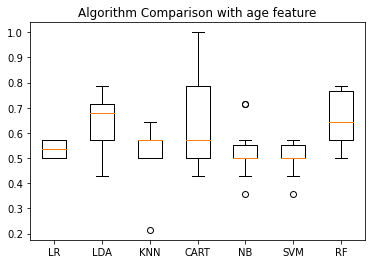

In [54]:
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison with age feature')
plt.show()

## Tuning hyperparameters and prediction (validation set)

In [55]:
# Evaluate predictions packages in order to be able to compute the performance measures.
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score



In [56]:
#Prepare output for the validation set in binary classification. 
count_control = 0
count_AD = 0

for i in range(len(dades_second)):
    idx = dades_second.index.values[i]
    #print(idx)
    
    if '3157' in idx: #5157 is the case where Tg group starts.
        index_ADtest = i

count_AD = len(dades_second) - index_ADtest #10
count_control = len(dades_second) - count_AD #12

y_validation = []

for i in range(len(dades_second)):
    if (i<count_control):
        y_validation.append(0)
    else:
        y_validation.append(1)
        
print(y_validation)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [57]:
#Prepare output for the validation set in multi-class classification. 

#count_control = 0
#count_AD = 0

#for i in range(len(dades_second)):
    #idx = dades_second.index.values[i]
    #print(idx)
    
    #if '3157' in idx: #5157 es on comença el AD. 
 #       index_ADtest = i

#count_AD = len(dades_second) - index_ADtest #10
#count_control = len(dades_second) - count_AD #12

#y_validation = []

#for i in range(len(dades_second)):
#    idx = dades_second.index.values[i]
    
#    if (i<count_control):
#        if ('t1' in idx) or ('t2' in idx) or ('t3' in idx):
#            y_validation.append(0) #Young-CTR
#        else:
#            y_validation.append(1) #Old-CTR
#    else:
#        if ('t1' in idx) or ('t2' in idx) or ('t3' in idx):
#            y_validation.append(2) #Young-Tg
#        else:
#            y_validation.append(3) #Old-Tg

#print(y_validation)

Once it has been chosen the classification model, we can decomment the code of interest. 

### Logistic regression

In [58]:
# Make predictions on validation dataset LR
#model_LR.fit(dades_first, y_train)
#predictions = model_LR.predict(dades_second)
#print(predictions)

#print(accuracy_score(y_validation, predictions))
#print(precision_score(y_validation, predictions))
#print(recall_score(y_validation, predictions))
#print(f1_score(y_validation, predictions))
#plot_confusion_matrix(model_LR, dades_second, y_validation, cmap=plt.cm.Blues)  
#plt.show()  

#lr_auc = roc_auc_score(y_validation, predictions)
#print(lr_auc)

### Decision Tree 

[0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 0 0 1 1 0 0 1 1]
0.7884615384615384
0.7391304347826086
0.7727272727272727
0.7555555555555555


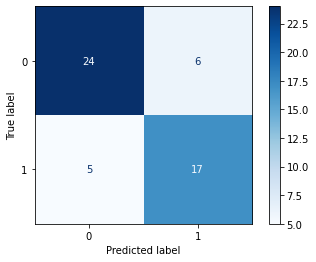

0.7863636363636364


In [59]:
# Make predictions on validation dataset DT
model_DT = DecisionTreeClassifier()
model_DT.fit(dades_first, y_train)
predictions = model_DT.predict(dades_second)
print(predictions)

print(accuracy_score(y_validation, predictions))
print(precision_score(y_validation, predictions))
print(recall_score(y_validation, predictions))
print(f1_score(y_validation, predictions))
plot_confusion_matrix(model_DT, dades_second, y_validation, cmap=plt.cm.Blues)  
plt.show()  

dt_auc = roc_auc_score(y_validation, predictions)
print(dt_auc)

### Linear Discriminant Analysis 

[1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1]
0.8076923076923077
0.75
0.8181818181818182
0.7826086956521738


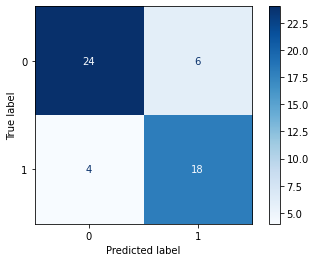

0.8090909090909092


In [60]:
# Make predictions on validation dataset LDA
model_LDA = LinearDiscriminantAnalysis()
model_LDA.fit(dades_first, y_train)
predictions = model_LDA.predict(dades_second)
print(predictions)

print(accuracy_score(y_validation, predictions))
print(precision_score(y_validation, predictions))
print(recall_score(y_validation, predictions))
print(f1_score(y_validation, predictions))
plot_confusion_matrix(model_LDA, dades_second, y_validation, cmap=plt.cm.Blues)  
plt.show() 

lda_auc = roc_auc_score(y_validation, predictions)
print(lda_auc)

### Support Vector Machine 

In [61]:
# Make predictions on validation dataset SVM
#model_SVM = SVC()
#model_SVM.fit(dades_first, y_train)
#predictions = model_SVM.predict(dades_second)
#print(predictions)

#print(accuracy_score(y_validation, predictions))
#print(precision_score(y_validation, predictions))
#print(recall_score(y_validation, predictions))
#print(f1_score(y_validation, predictions))
#plot_confusion_matrix(model_SVM, dades_second, y_validation, cmap=plt.cm.Blues)  
#plt.show() 

#svm_auc = roc_auc_score(y_validation, predictions)
#print(svm_auc)

### KNN 

In [62]:
# Make predictions on validation dataset KNN
#model_KNN = KNeighborsClassifier()
#model_KNN.fit(dades_first, y_train)
#predictions = model_KNN.predict(dades_second)
#print(predictions)

#print(accuracy_score(y_validation, predictions))
#print(precision_score(y_validation, predictions))
#print(recall_score(y_validation, predictions))
#print(f1_score(y_validation, predictions))
#plot_confusion_matrix(model_KNN, dades_second, y_validation, cmap=plt.cm.Blues)  
#plt.show() 

#knn_auc = roc_auc_score(y_validation, predictions)
#print(knn_auc)

### Naive Bayes 

In [63]:
# Make predictions on validation dataset NB
#model_NB = GaussianNB()
#model_NB.fit(dades_first, y_train)
#predictions = model_NB.predict(dades_second)
#print(predictions)

#print(accuracy_score(y_validation, predictions))
#print(precision_score(y_validation, predictions))
#print(recall_score(y_validation, predictions))
#print(f1_score(y_validation, predictions))
#plot_confusion_matrix(model_NB, dades_second, y_validation, cmap=plt.cm.Blues)  
#plt.show() 

#nb_auc = roc_auc_score(y_validation, predictions)
#print(nb_auc)

### Random Forest 

[0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 0
 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1]
0.7692307692307693
0.6923076923076923
0.8181818181818182
0.7500000000000001


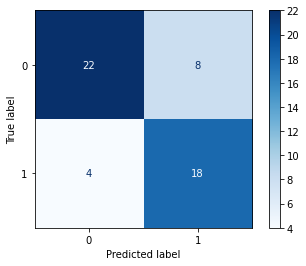

0.7757575757575759


In [64]:
# Make predictions on validation dataset RF
model_RF = RandomForestClassifier()
model_RF.fit(dades_first, y_train)
predictions = model_RF.predict(dades_second)
print(predictions)

print(accuracy_score(y_validation, predictions))
print(precision_score(y_validation, predictions))
print(recall_score(y_validation, predictions))
print(f1_score(y_validation, predictions))
plot_confusion_matrix(model_RF, dades_second, y_validation, cmap=plt.cm.Blues)  
plt.show()

rf_auc = roc_auc_score(y_validation, predictions)
print(rf_auc)